# Spray Vision Report Plots

This notebook generates and saves all requested plots using the processed dataset and trained models.

**Inputs:**
- time, chamb_pressure, cham_temp, injection_pres, density, viscosity

**Targets:**
- angle_mie, length_mie, angle_shadow, length_shadow

All plots will be saved in a dedicated `plots` folder in the project root.

In [2]:
# %%
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

rc = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 7,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.titlesize": 7,
    "figure.dpi": 400,
    "savefig.dpi": 400,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.01,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "xtick.minor.size": 1.5,
    "ytick.minor.size": 1.5,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
    "grid.linewidth": 0.3,
}
mpl.rcParams.update(rc)
sns.set_theme(context="paper", style="whitegrid", rc=rc)

def fig_mm(width_mm=85, height_mm=70, nrows=1, ncols=1, **kwargs):
    inches = (width_mm / 25.4, height_mm / 25.4)
    return plt.subplots(nrows=nrows, ncols=ncols, figsize=inches, constrained_layout=True, **kwargs)


In [3]:
# %%
import os
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

os.makedirs("plots", exist_ok=True)


In [4]:
# %%
SINGLE_COL_WIDTH = 3.5
ONE_FIVE_COL_WIDTH = 5.5
DOUBLE_COL_WIDTH = 7

def get_figsize(width_inches, aspect_ratio=1.618):
    return (width_inches, width_inches / aspect_ratio)


In [5]:
# %%
df = pd.read_csv("data/processed/preprocessed_dataset.csv")

rename_map = {
    "Time_ms": "time",
    "Pc_bar": "chamb_pressure",
    "Tc_K": "cham_temp",
    "Pinj_bar": "injection_pres",
    "rho_kgm3": "density",
    "mu_Pas": "viscosity",
    "angle_shadow_deg": "angle_shadow",
    "len_shadow_L_D": "length_shadow",
    "angle_mie_deg": "angle_mie",
    "len_mie_L_D": "length_mie",
}
df = df.rename(columns=rename_map)
INPUTS = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

print(f"Dataset Loaded. Shape: {df.shape}")


Dataset Loaded. Shape: (726, 11)


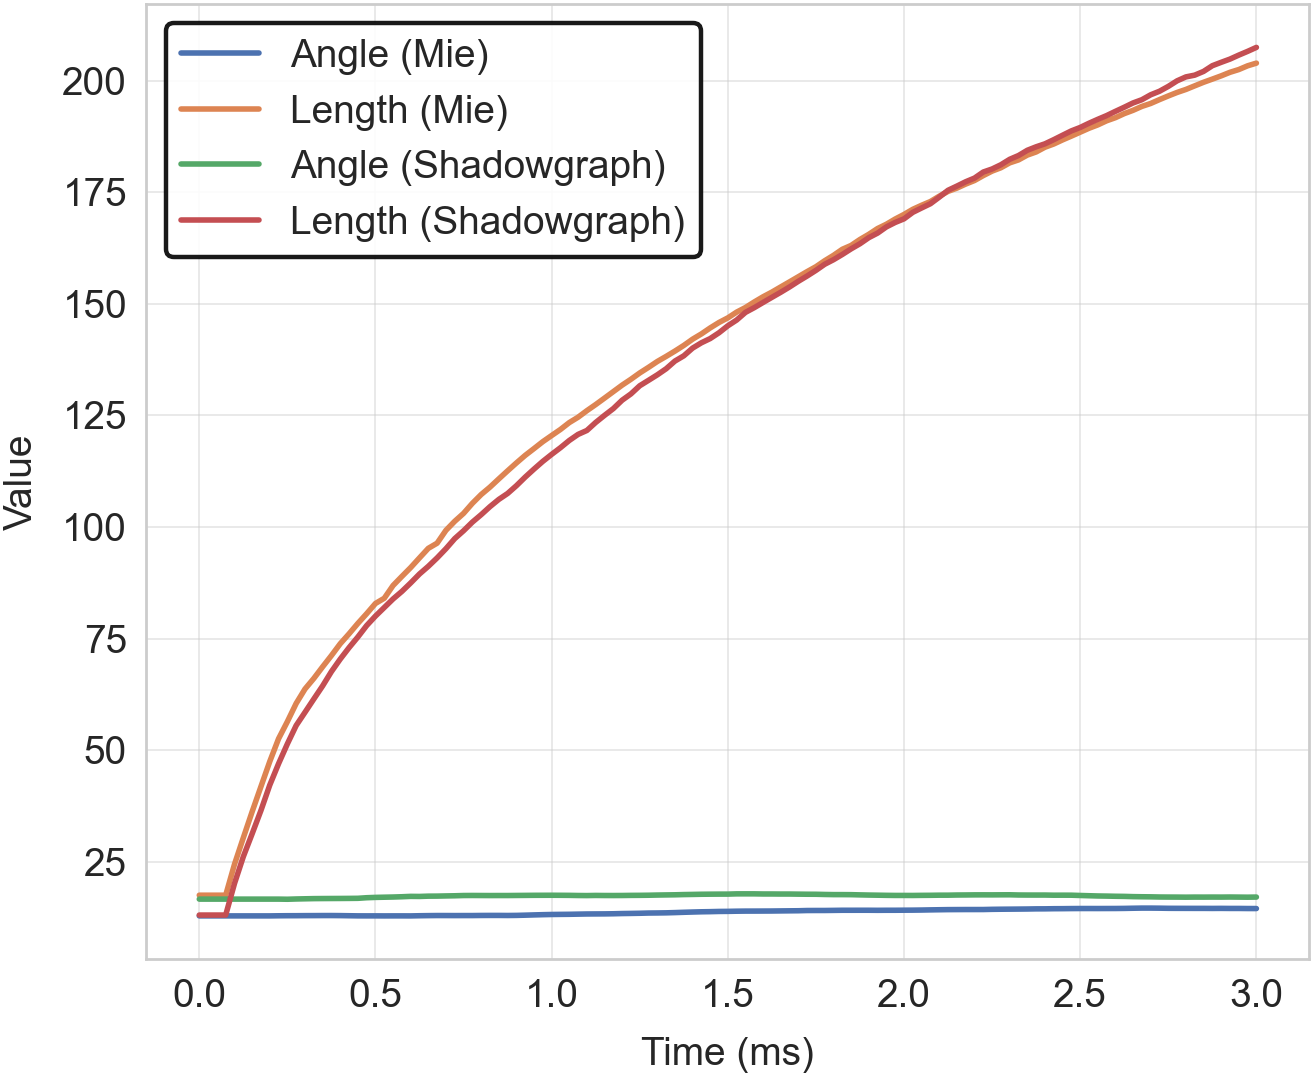

In [6]:
# %%
run_df = df.iloc[:121].copy()
fig, ax = fig_mm(85, 70)
ax.plot(run_df["time"], run_df["angle_mie"], label="Angle (Mie)")
ax.plot(run_df["time"], run_df["length_mie"], label="Length (Mie)")
ax.plot(run_df["time"], run_df["angle_shadow"], label="Angle (Shadowgraph)")
ax.plot(run_df["time"], run_df["length_shadow"], label="Length (Shadowgraph)")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Value")
ax.grid(True, alpha=0.5)
ax.legend(frameon=True, edgecolor="black", framealpha=0.9)
fig.savefig("plots/1_time_dependent_spray_angle_length.png")
plt.show()


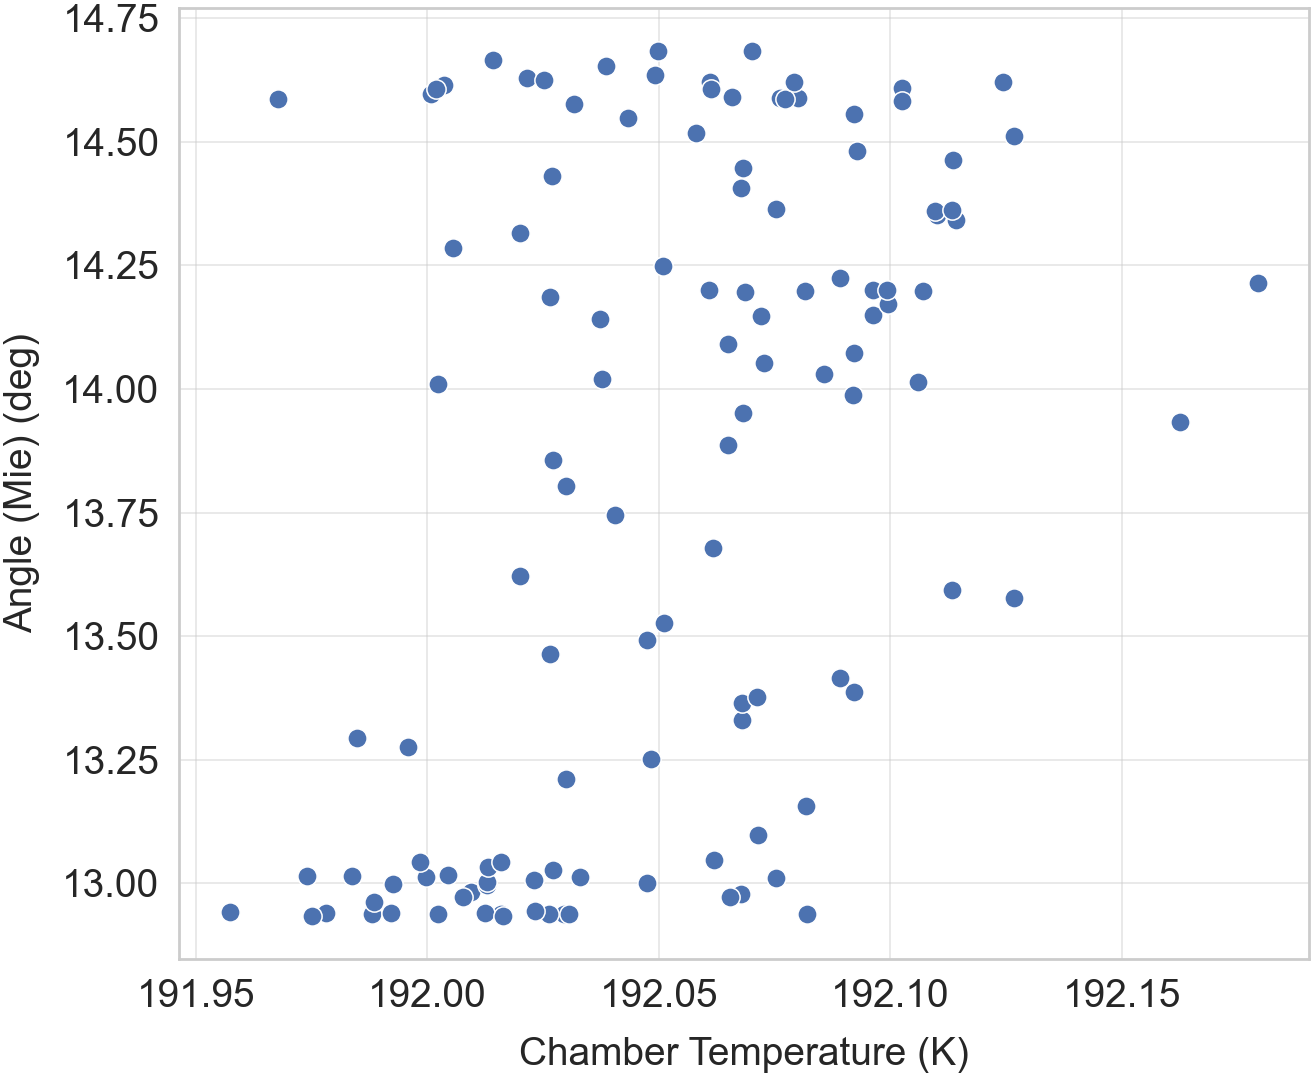

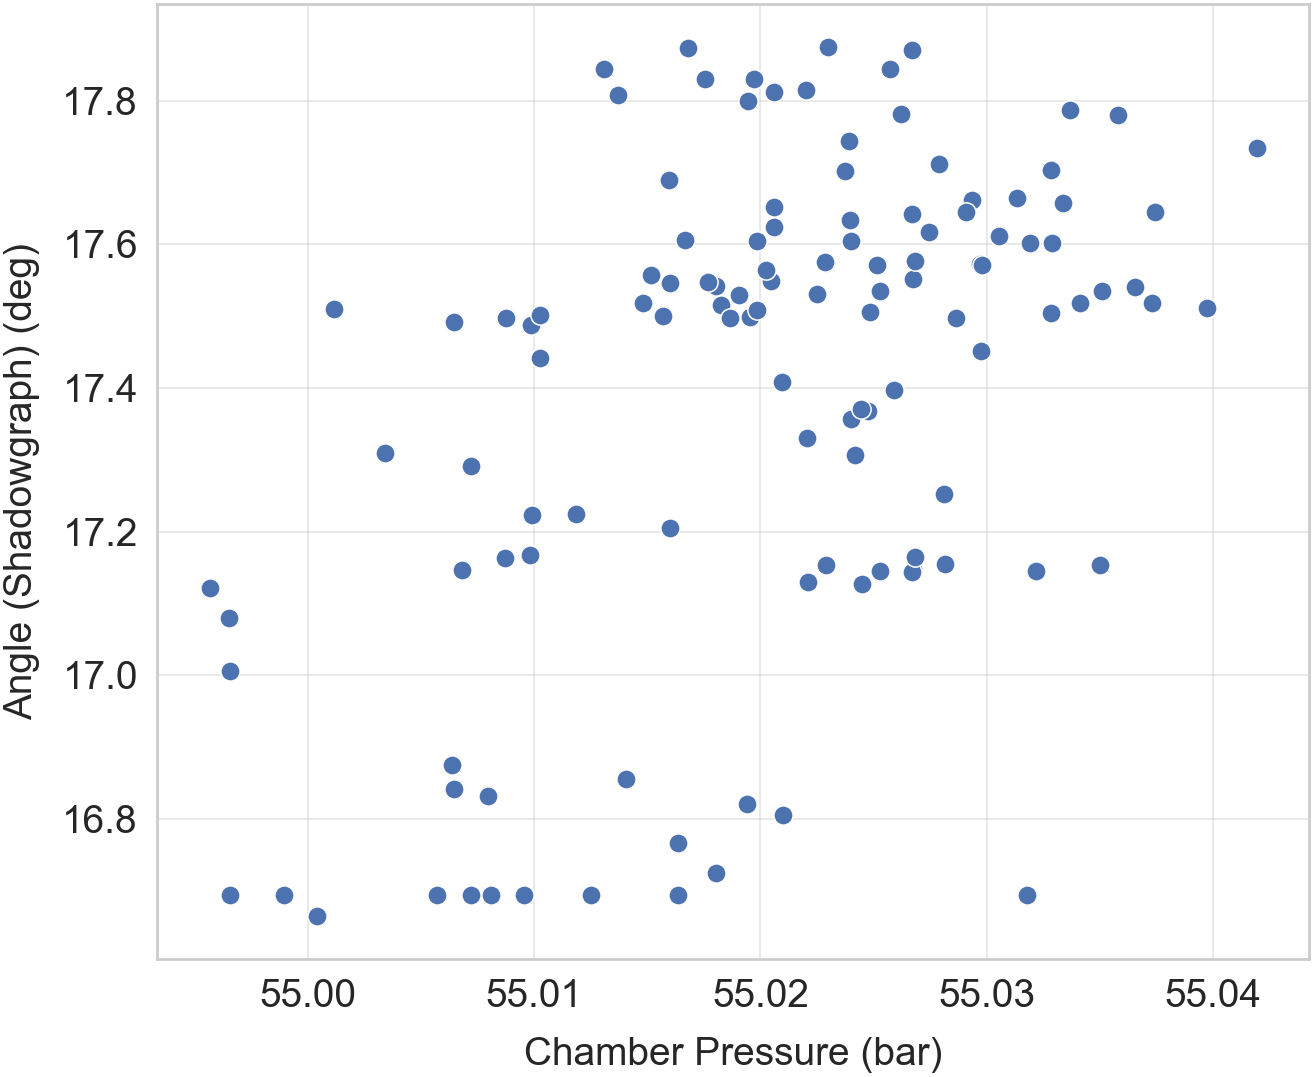

In [7]:
# %%
fig, ax = fig_mm(85, 70)
sns.scatterplot(x="cham_temp", y="angle_mie", data=run_df, ax=ax, s=12)
ax.set_xlabel("Chamber Temperature (K)")
ax.set_ylabel("Angle (Mie) (deg)")
ax.grid(True, alpha=0.5)
fig.savefig("plots/2a_cham_temp_vs_angle_mie.png")
plt.show()

fig, ax = fig_mm(85, 70)
sns.scatterplot(x="chamb_pressure", y="angle_shadow", data=run_df, ax=ax, s=12)
ax.set_xlabel("Chamber Pressure (bar)")
ax.set_ylabel("Angle (Shadowgraph) (deg)")
ax.grid(True, alpha=0.5)
fig.savefig("plots/2b_chamb_pressure_vs_angle_shadow.png")
plt.show()


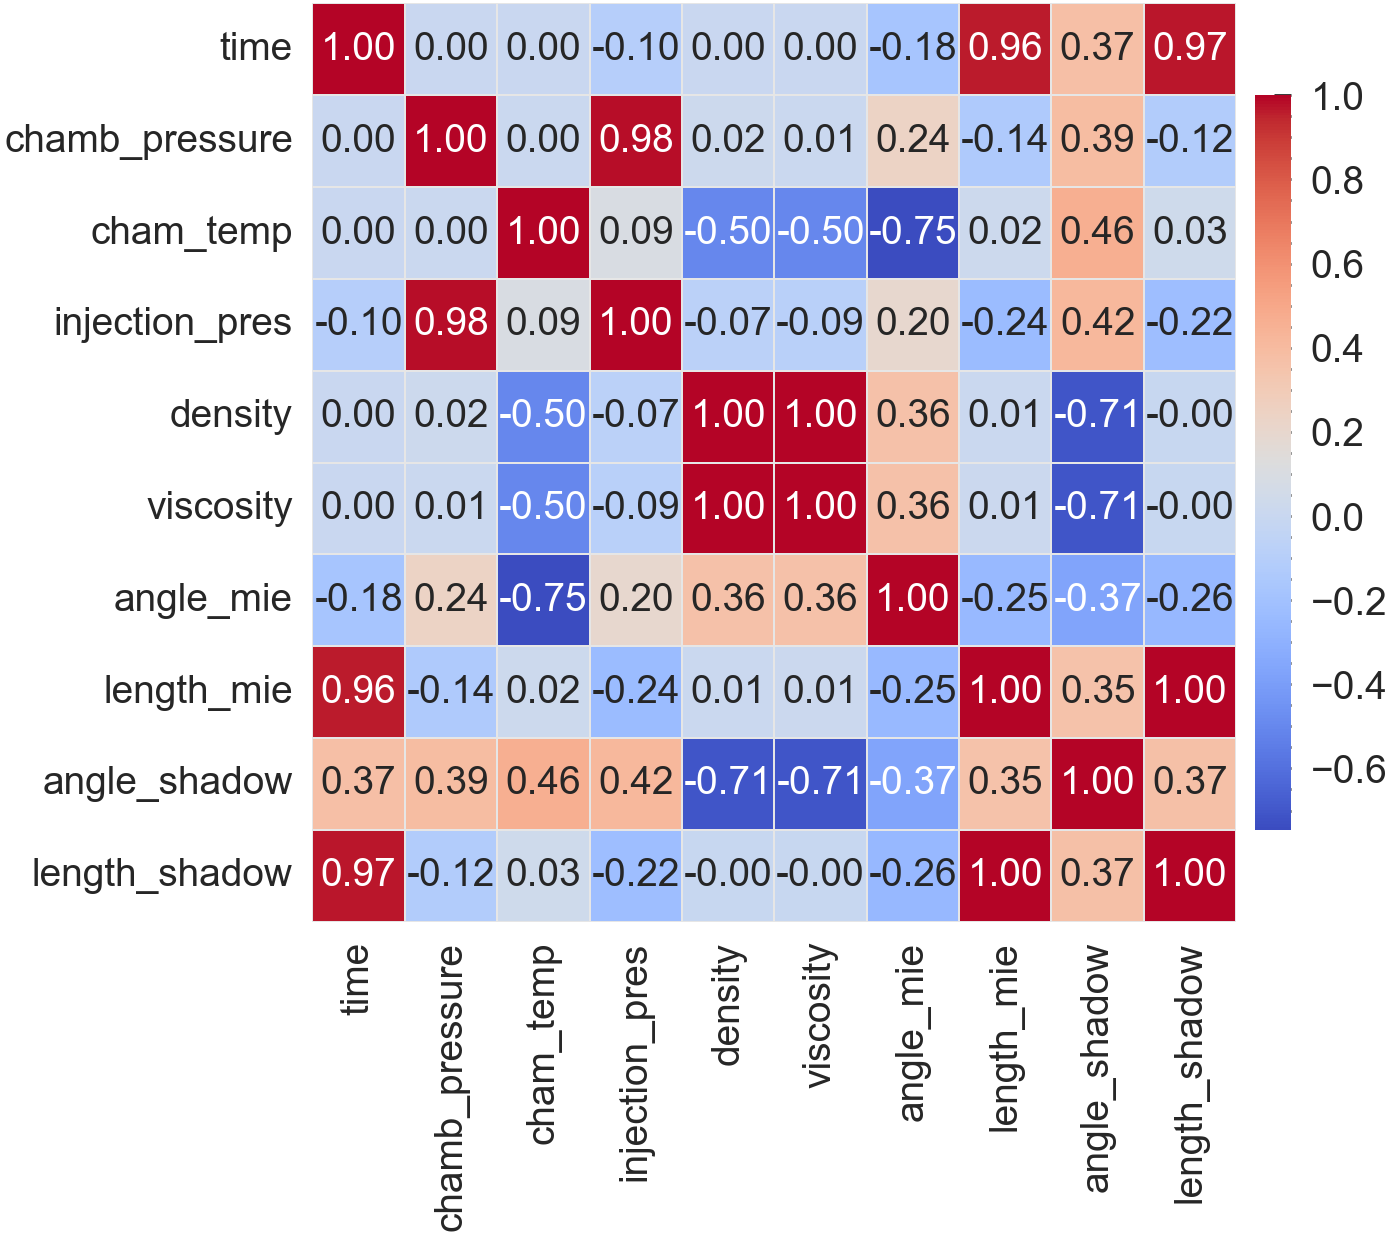

In [8]:
# %%
corr = df[INPUTS + TARGETS].corr()
fig, ax = fig_mm(90, 80)
sns.heatmap(corr, ax=ax, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.8, "pad": 0.02},
            linewidths=0.3, linecolor="0.9")
fig.savefig("plots/3_correlation_heatmap.png")
plt.show()


In [9]:
# %%
X = df[INPUTS].values
Y_shadow = df[["angle_shadow", "length_shadow"]].values
Y_mie = df[["angle_mie", "length_mie"]].values

X_train, X_test, y_shadow_train, y_shadow_test, y_mie_train, y_mie_test = train_test_split(
    X, Y_shadow, Y_mie, test_size=0.2, random_state=42
)


In [11]:
# %%
def get_gb_predictions(X_tr, X_te, y_tr, y_te):
    gb_model_path = "models/GradientBoosting_regressor.joblib"
    gb_model = joblib.load(gb_model_path)
    gb_model.fit(X_tr, y_tr)
    y_pred = gb_model.predict(X_te)
    return y_te, y_pred

y_shadow_true, y_shadow_pred = get_gb_predictions(X_train, X_test, y_shadow_train, y_shadow_test)
y_mie_true, y_mie_pred = get_gb_predictions(X_train, X_test, y_mie_train, y_mie_test)


In [12]:
# %%
def plot_individual_time_series_separate(y_true, y_pred, label):
    fig, ax = fig_mm(85, 70)
    ax.plot(y_true, label=f"True {label}", color="tab:blue")
    ax.plot(y_pred, label=f"Predicted {label}", color="tab:orange")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel(label)
    ax.grid(True, alpha=0.5)
    ax.legend(loc="upper right", frameon=True, edgecolor="black", framealpha=0.9)
    safe_label = label.replace(" ", "_").replace("(", "").replace(")", "")
    fig.savefig(f"plots/4_predicted_vs_actual_line_plot_for_{safe_label}.png")
    plt.show()


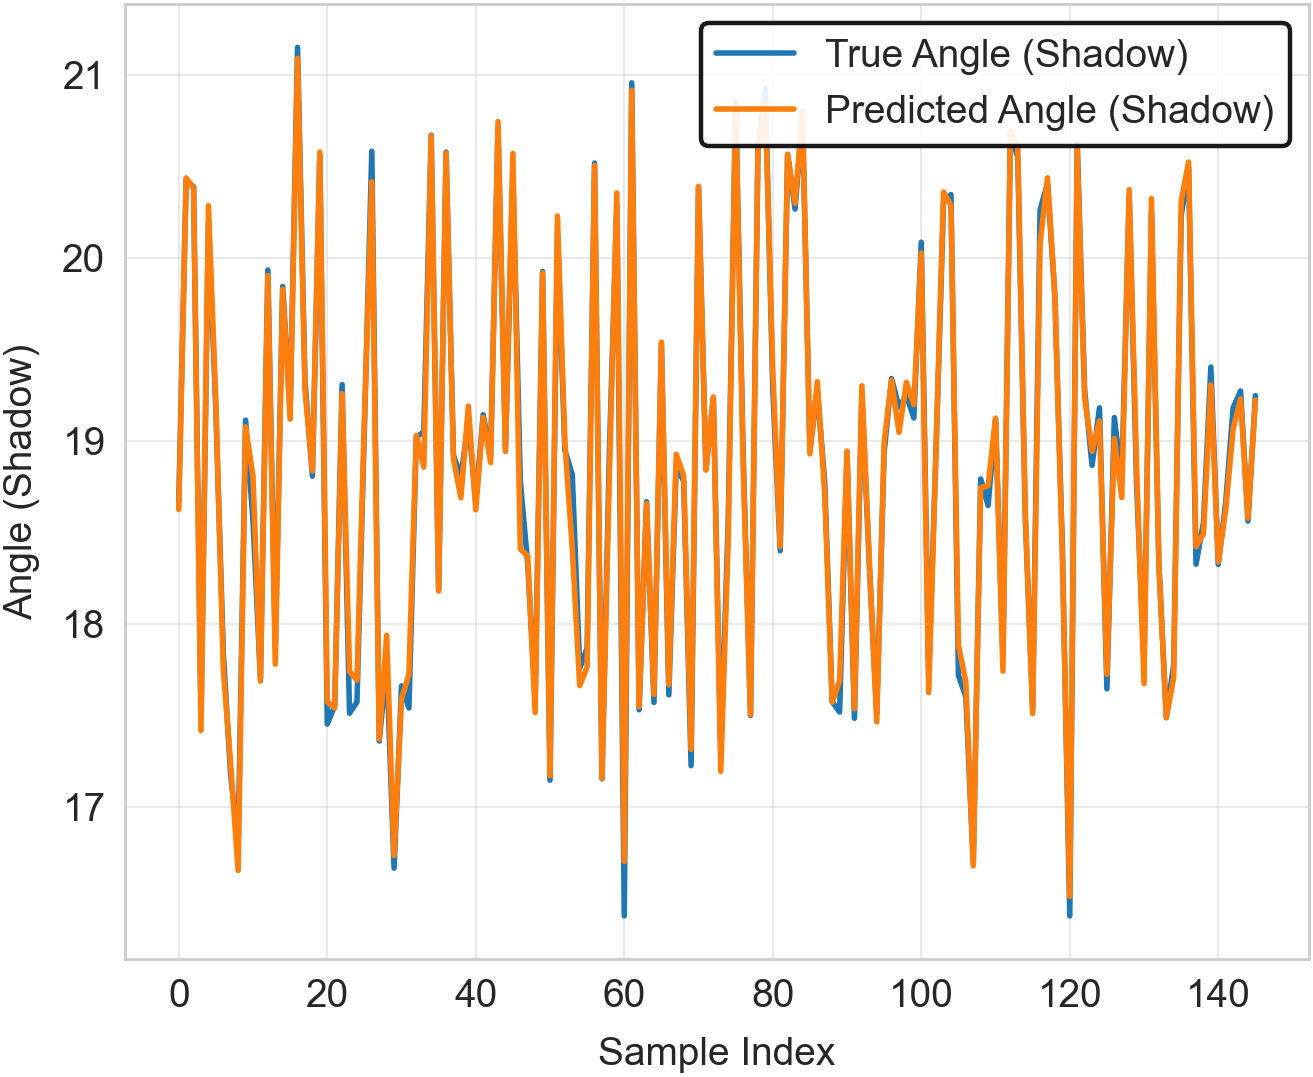

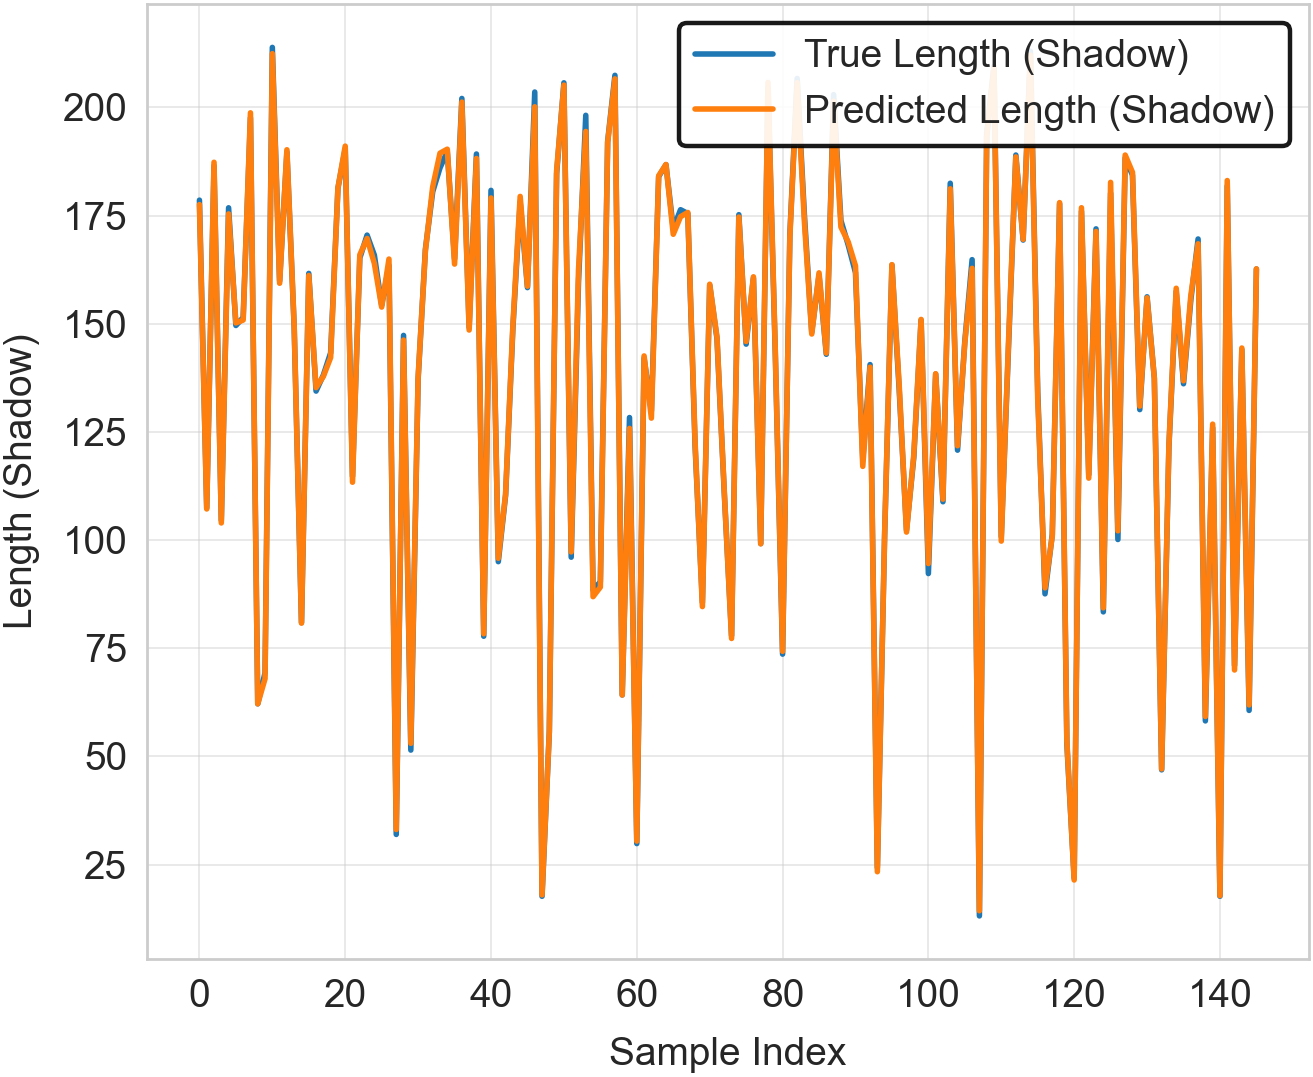

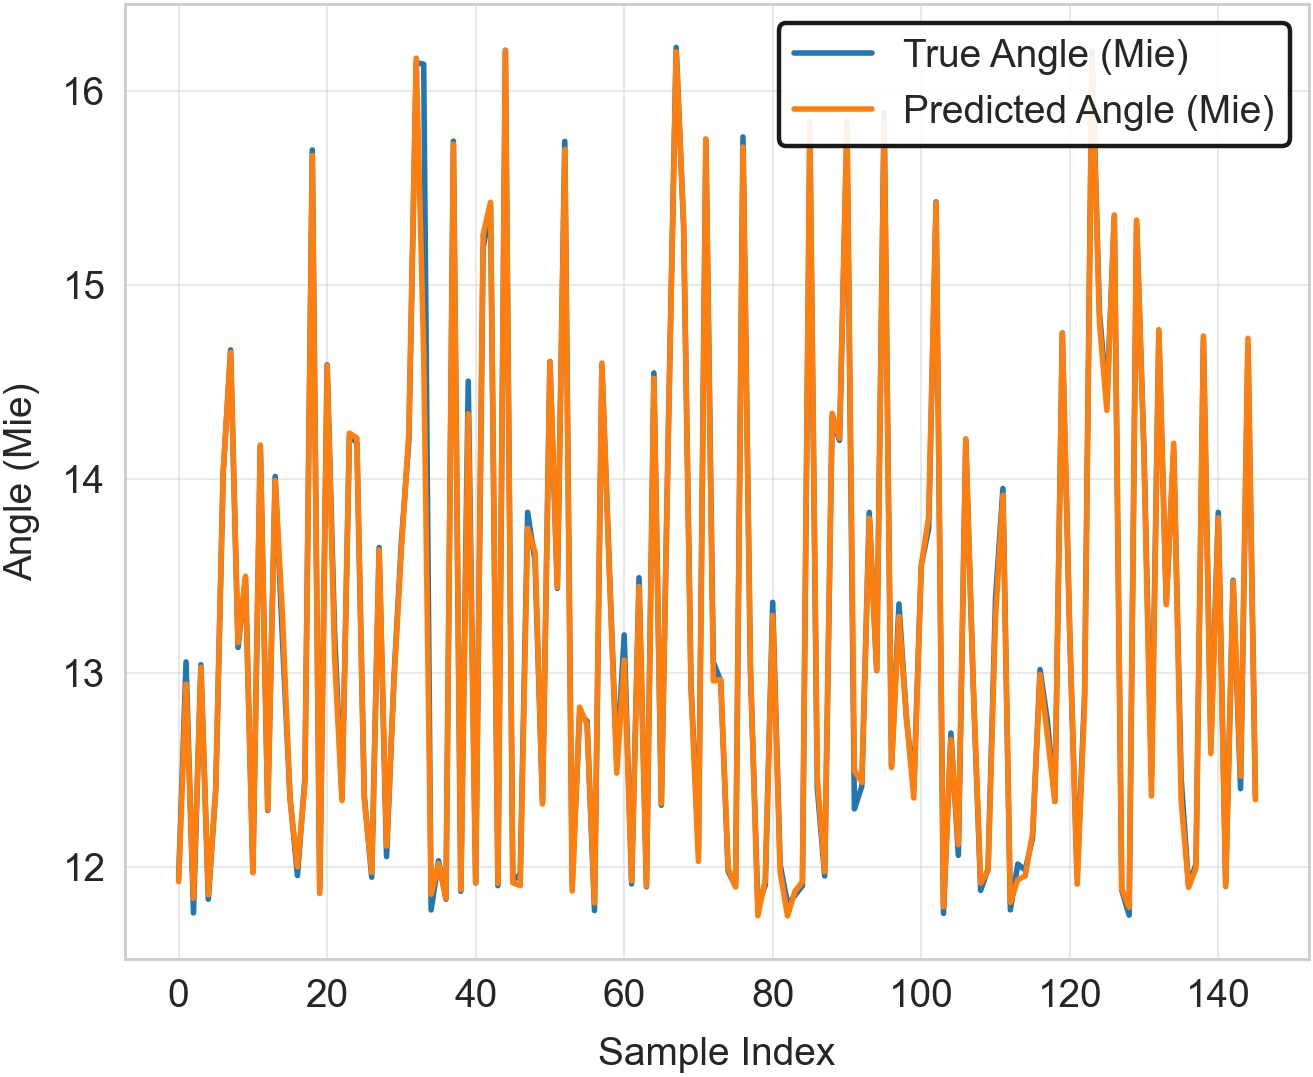

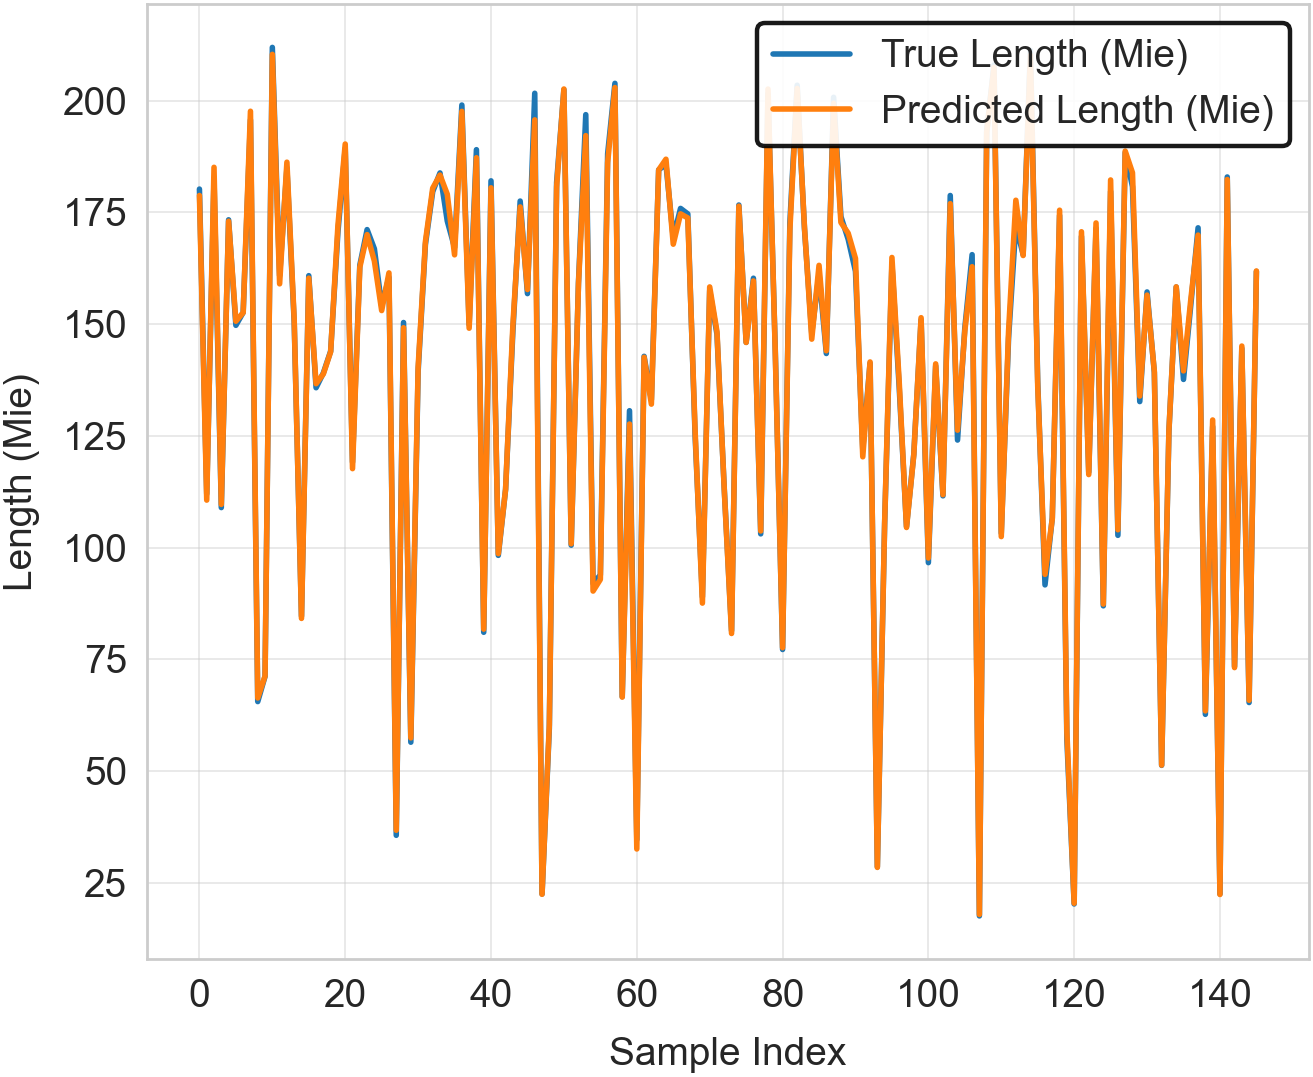

In [13]:
# %%
plot_individual_time_series_separate(y_shadow_true[:, 0], y_shadow_pred[:, 0], "Angle (Shadow)")
plot_individual_time_series_separate(y_shadow_true[:, 1], y_shadow_pred[:, 1], "Length (Shadow)")
plot_individual_time_series_separate(y_mie_true[:, 0], y_mie_pred[:, 0], "Angle (Mie)")
plot_individual_time_series_separate(y_mie_true[:, 1], y_mie_pred[:, 1], "Length (Mie)")


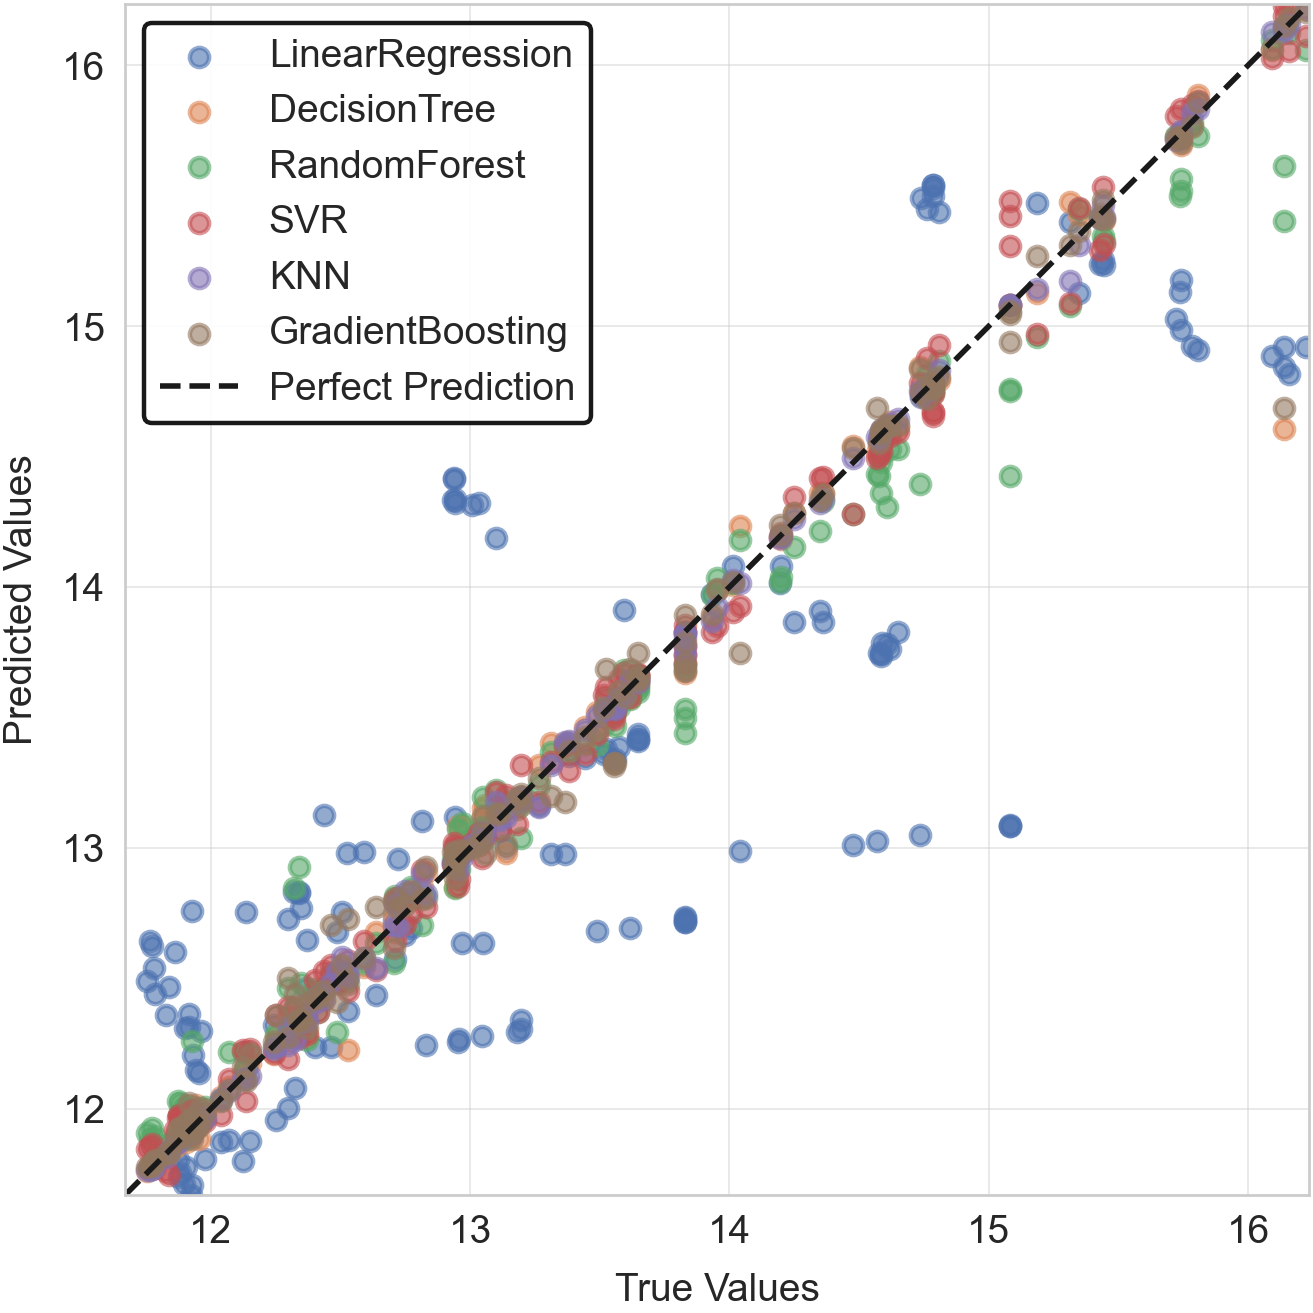

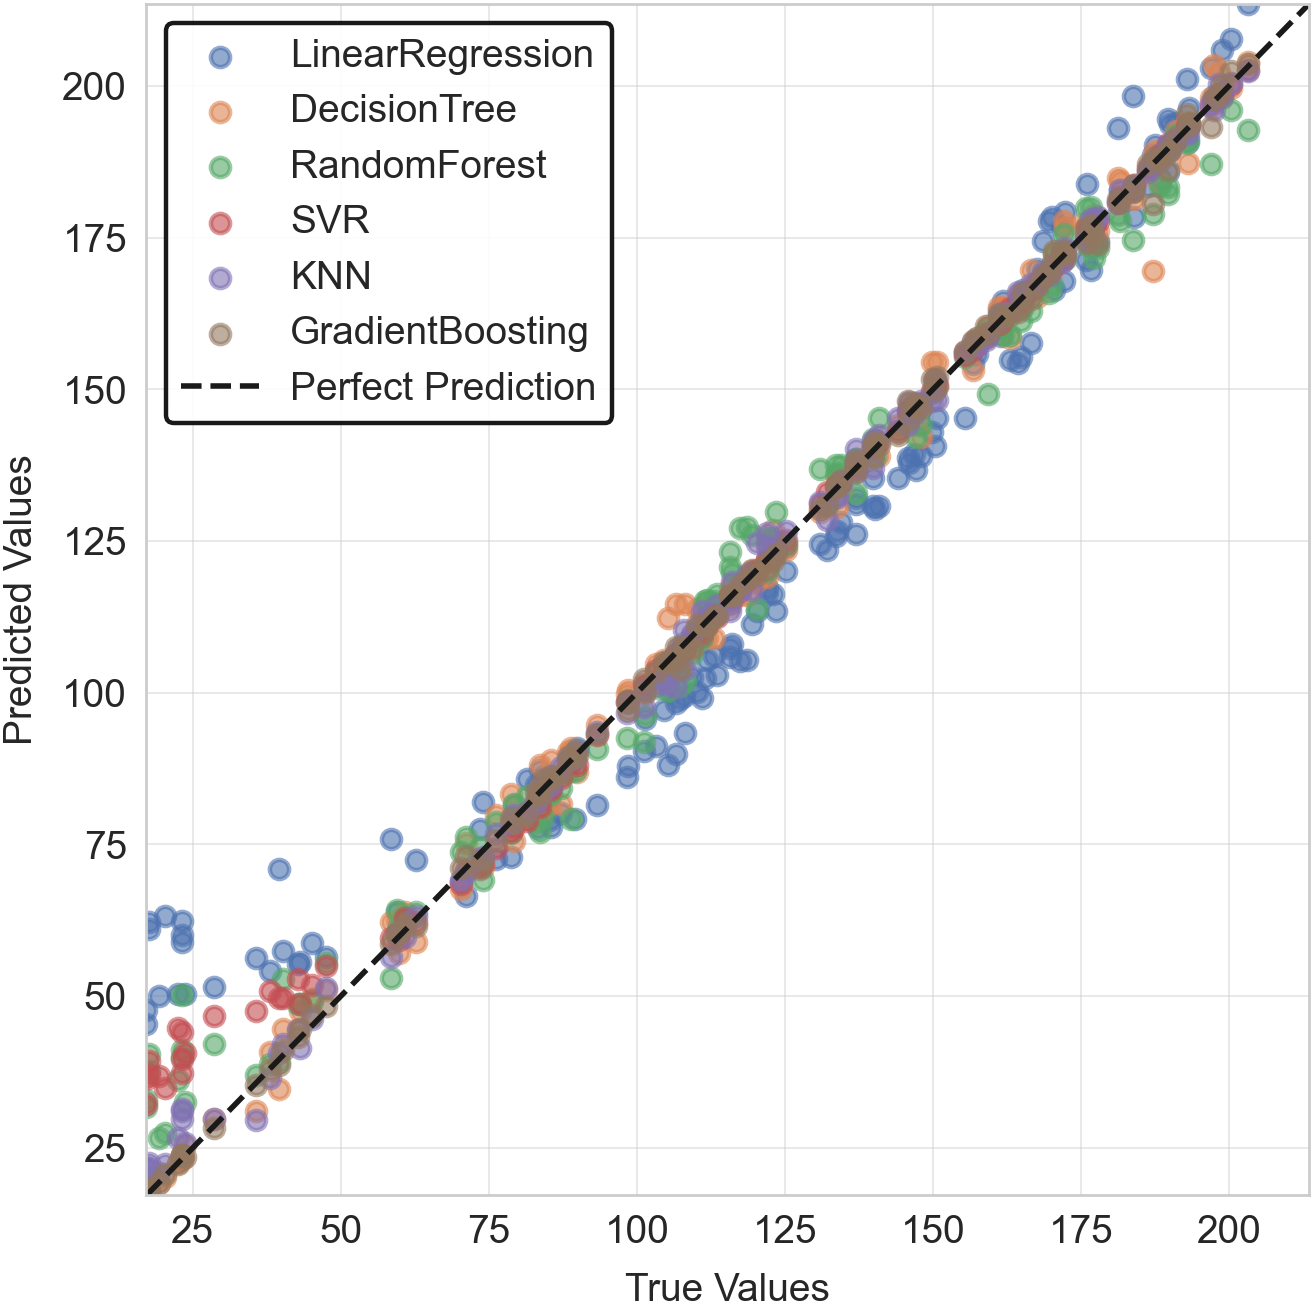

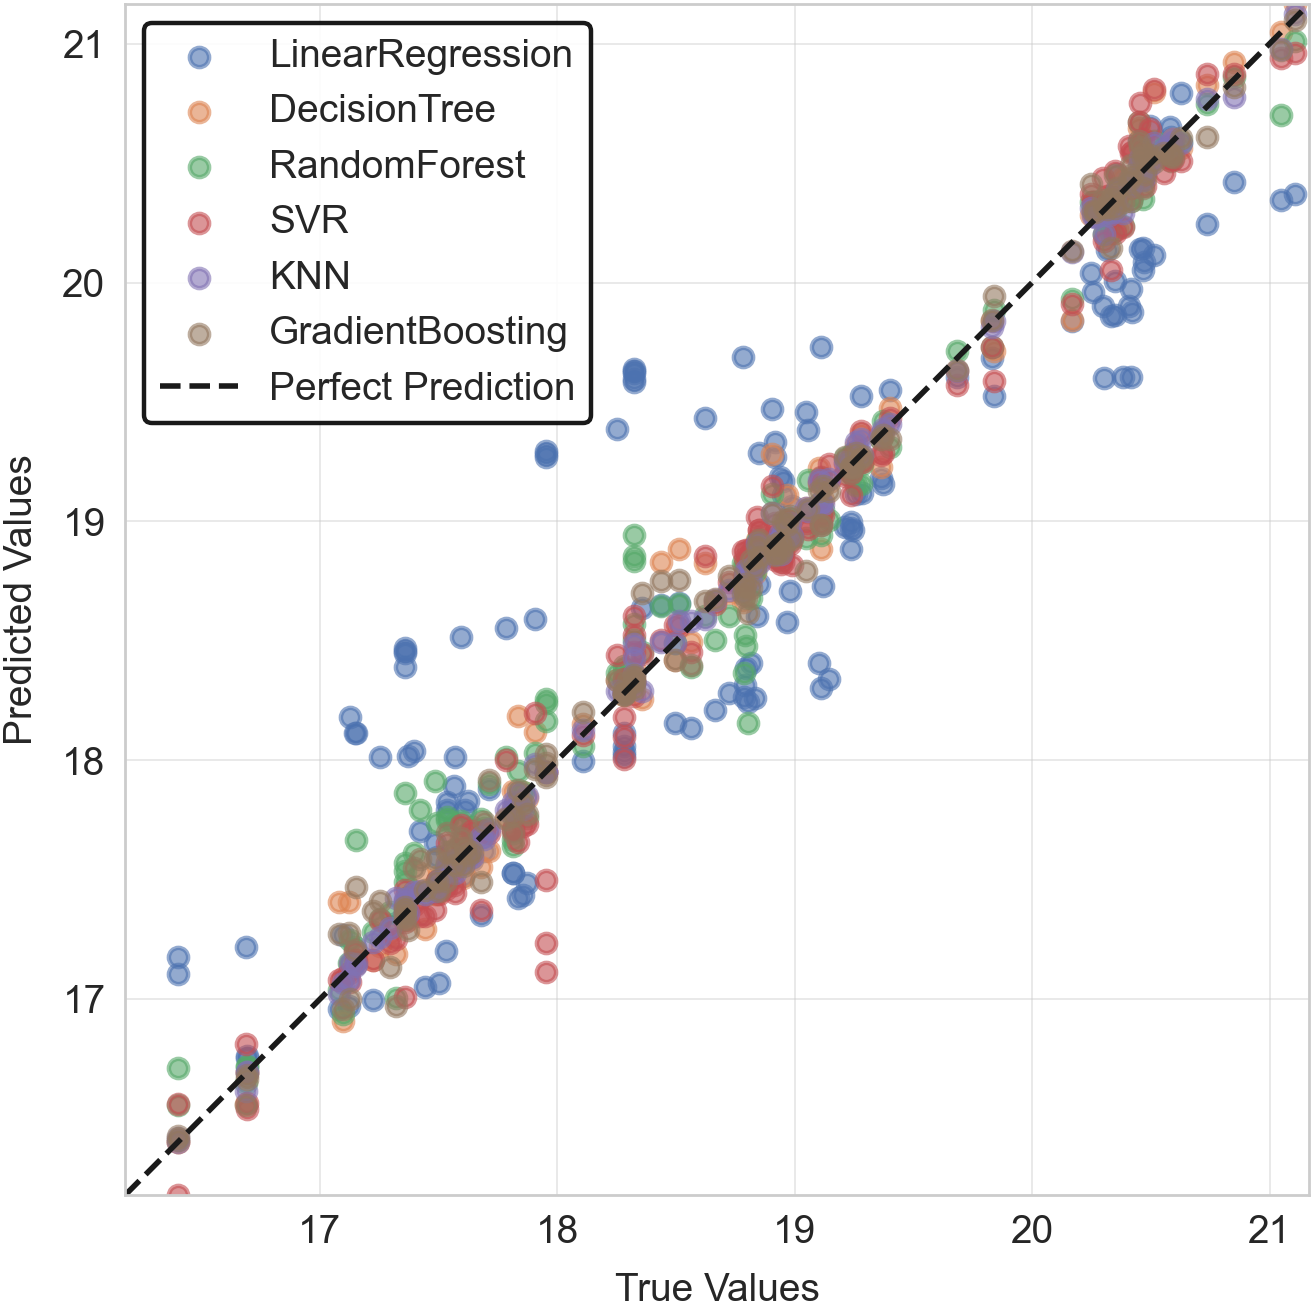

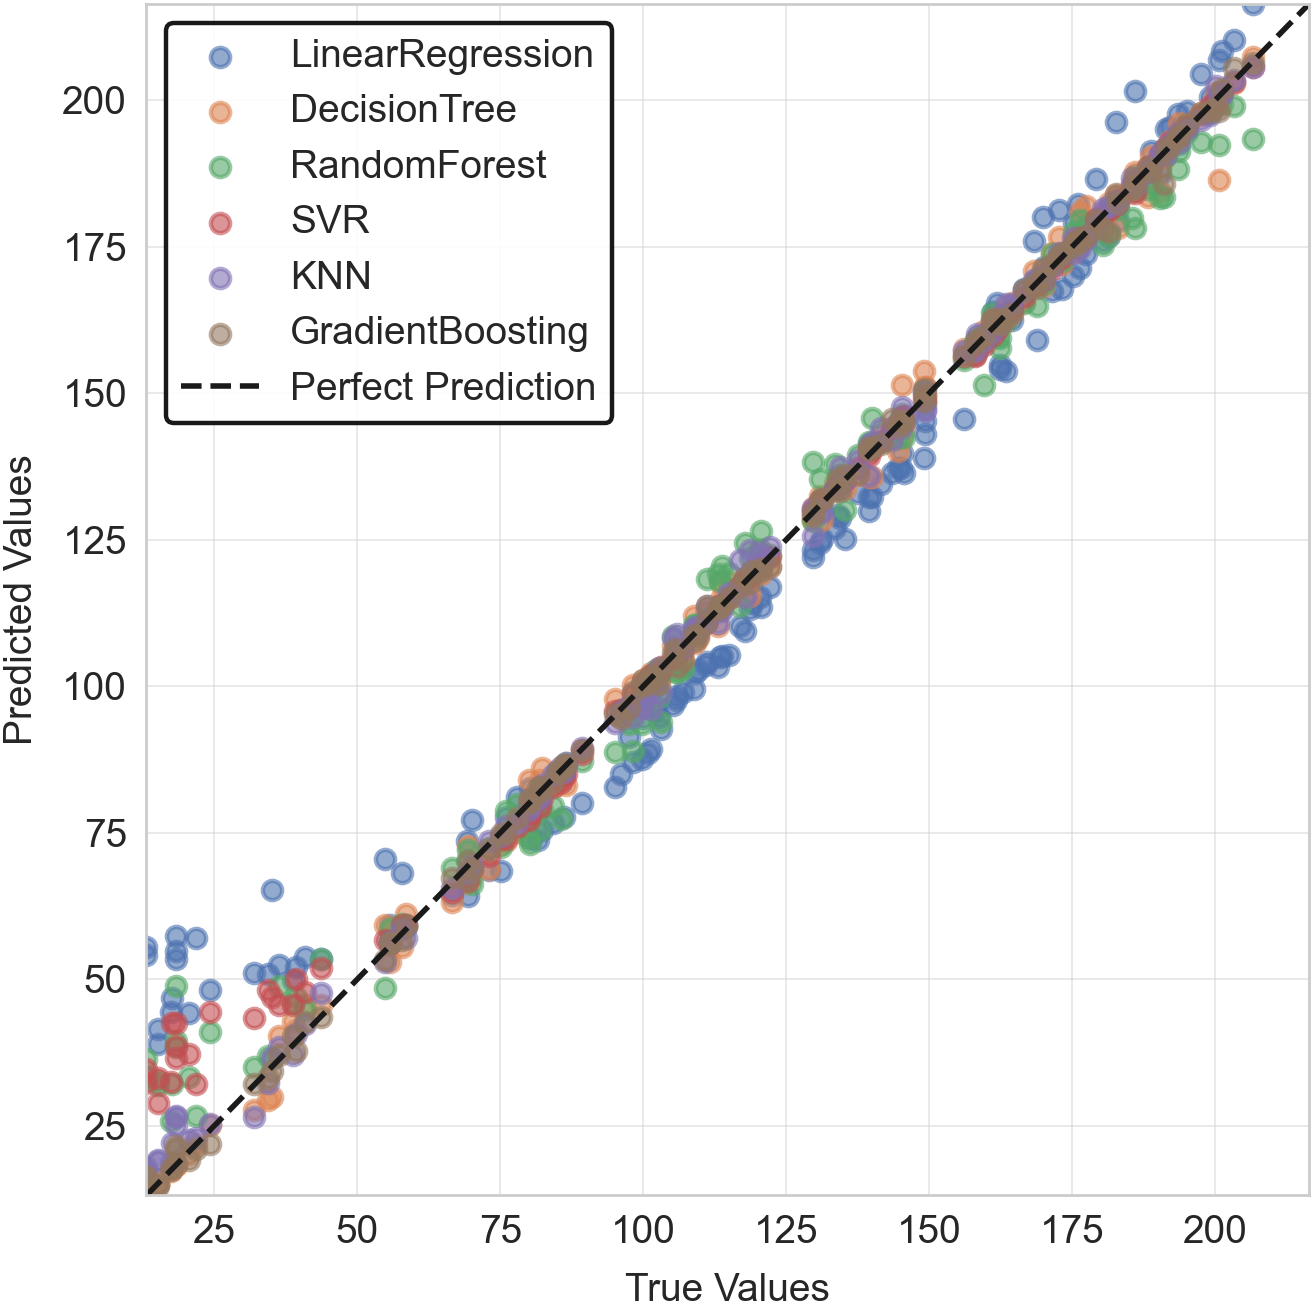

In [15]:
# %%
X, y = df[INPUTS], df[TARGETS]

if 'run' in df.columns:
  runs = df["run"]
  X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)
else:
  print("Warning: 'run' column not found. Performing split without stratification.")
  X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42)

model_names = ["LinearRegression", "DecisionTree", "RandomForest", "SVR", "KNN", "GradientBoosting"]

for target_index, target in enumerate(TARGETS):
  fig, ax = fig_mm(85, 85)
  all_preds = []
  for mdl_name in model_names:
    model_path = f"models/{mdl_name}_regressor.joblib"
    if os.path.exists(model_path):
      model = joblib.load(model_path)
      y_pred = model.predict(X_te)[:, target_index]
      all_preds.append(y_pred)
      ax.scatter(y_te[target], y_pred, label=mdl_name, alpha=0.6, s=12)
    else:
      print(f"Model {mdl_name} not found.")
  if all_preds:
    y_true_vals = y_te[target].values
    y_pred_concat = np.concatenate(all_preds)
    max_val = max(y_true_vals.max(), y_pred_concat.max())
    min_val = min(y_true_vals.min(), y_pred_concat.min())
    ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1.0, label="Perfect Prediction")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
  ax.set_xlabel("True Values")
  ax.set_ylabel("Predicted Values")
  ax.legend(ncol=1, loc="upper left", frameon=True, edgecolor="black", framealpha=0.9)
  ax.grid(True, alpha=0.5)
  fig.savefig(f"plots/5_parity_plot_for_{target}.png")
  plt.show()


In [16]:
# %%
TARGET_FOR_ANALYSIS = "angle_mie"
target_index = TARGETS.index(TARGET_FOR_ANALYSIS)
y_te_target = y_te[TARGET_FOR_ANALYSIS]
results = {}

for mdl_name in model_names:
    model_path = f"models/{mdl_name}_regressor.joblib"
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        y_pred_all = model.predict(X_te)
        y_pred_target = y_pred_all[:, target_index]
        residuals = y_te_target - y_pred_target
        results[mdl_name] = {"predictions": y_pred_target, "residuals": residuals}
    else:
        print(f"Warning: Model file not found at {model_path}. Skipping {mdl_name}.")


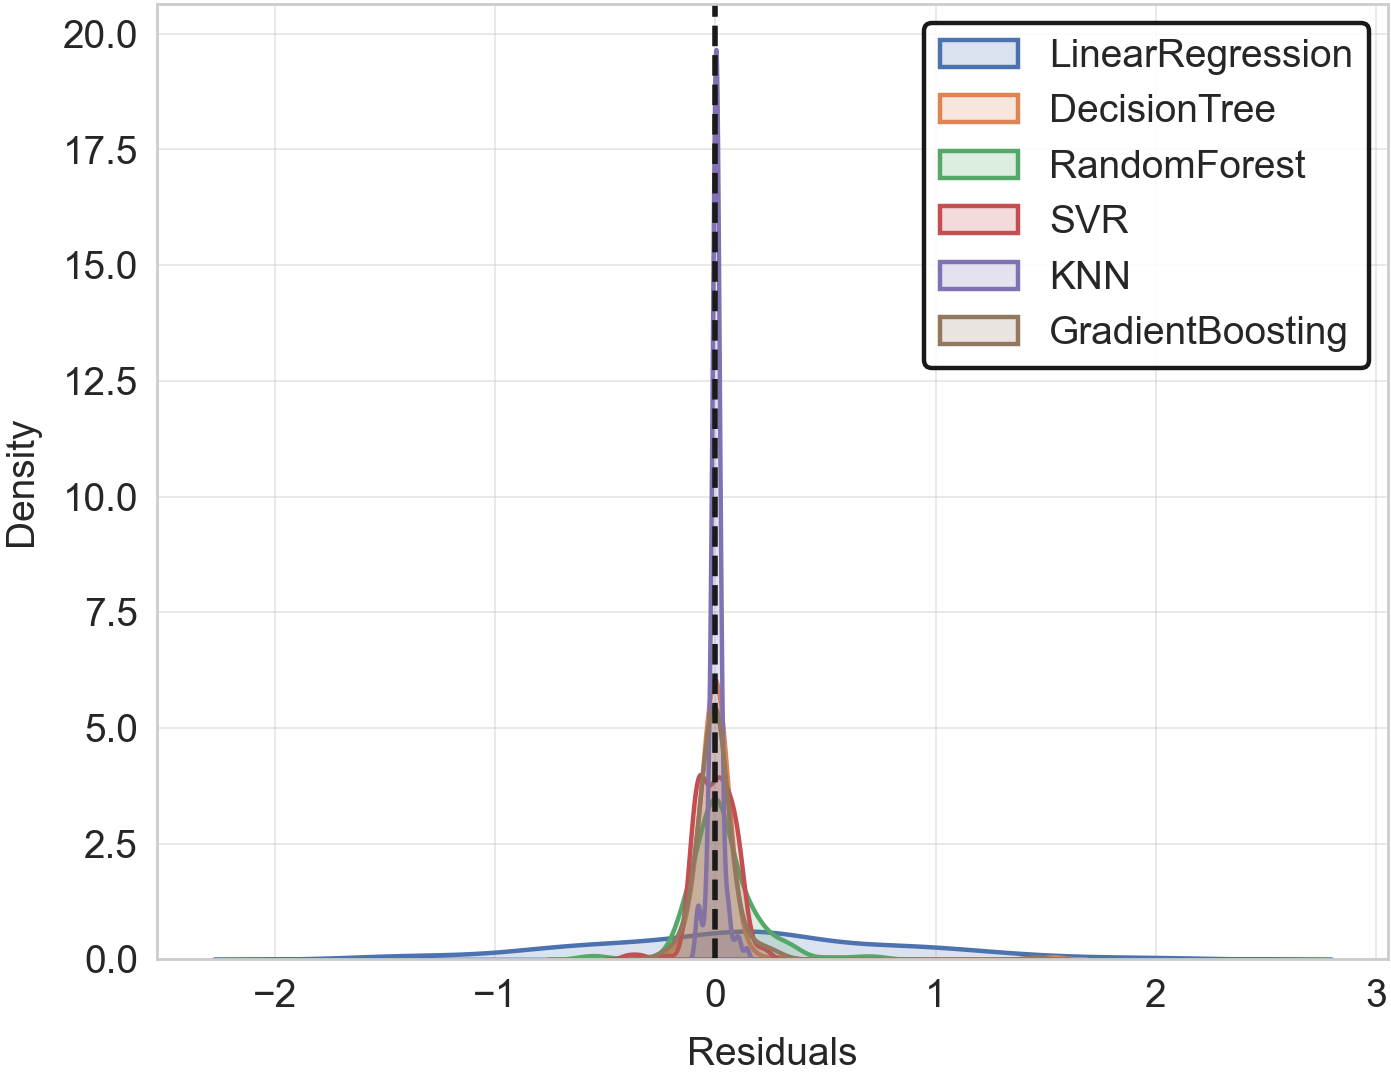

In [17]:
# %%
fig, ax1 = fig_mm(90, 70)
for name, data in results.items():
    sns.kdeplot(data["residuals"], ax=ax1, label=name, fill=True, alpha=0.2)
ax1.axvline(x=0, color="k", linestyle="--", linewidth=1.0)
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Density")
ax1.legend(frameon=True, edgecolor="black", framealpha=0.9)
ax1.grid(True, alpha=0.5)
fig.savefig("plots/6a_kde_residuals_angle_mie.png")
plt.show()


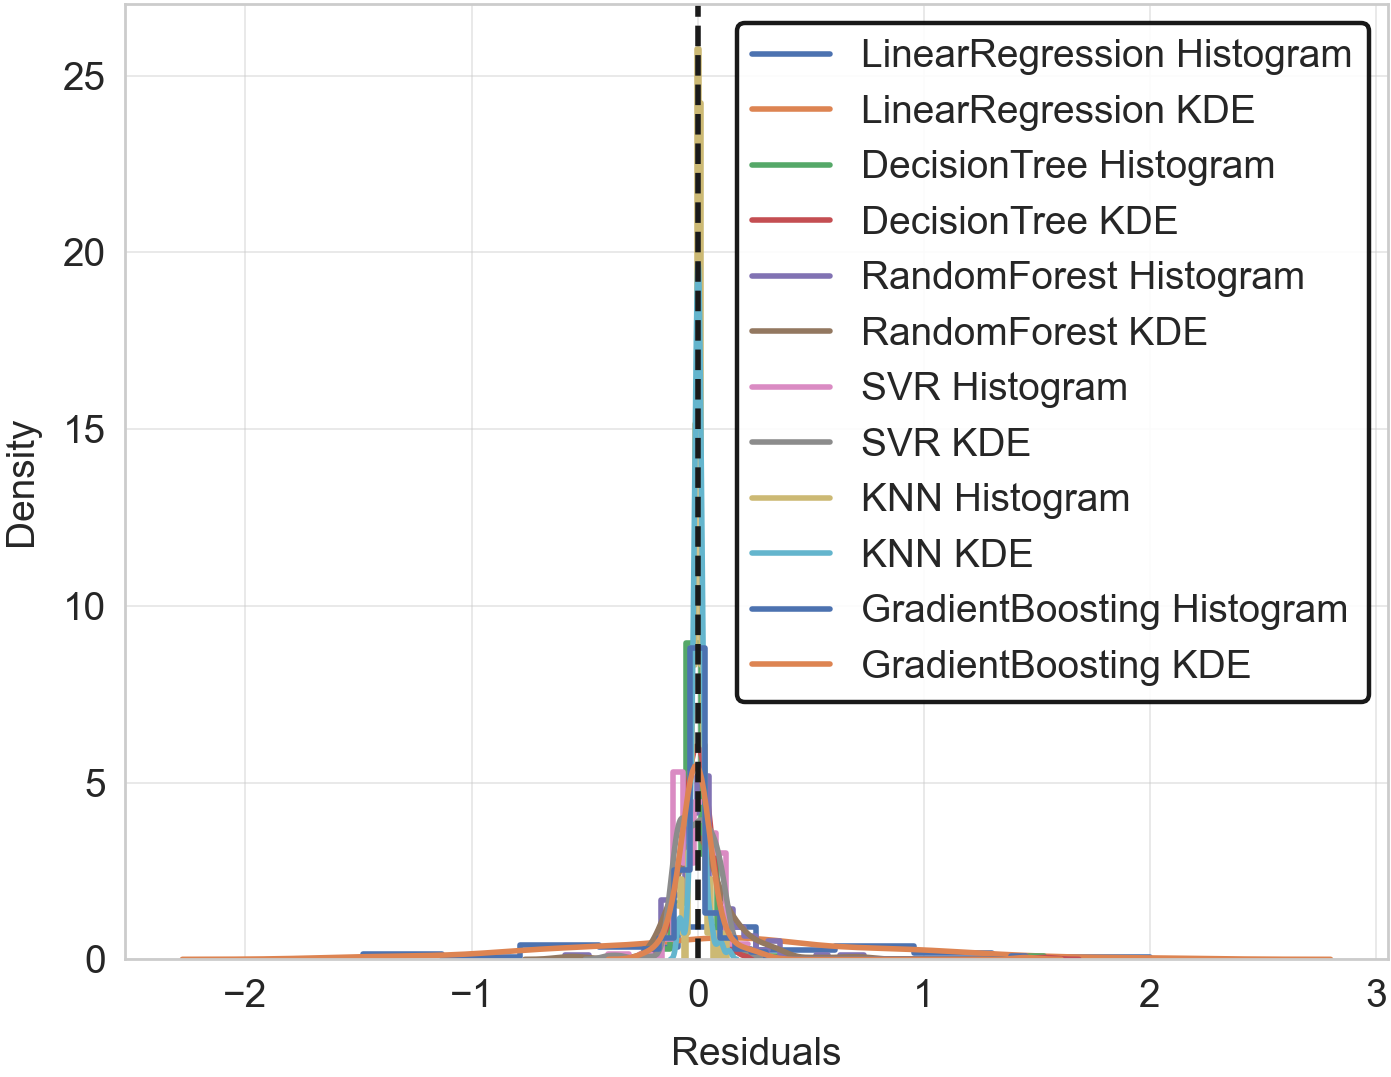

In [18]:
# %%
fig, ax2 = fig_mm(90, 70)
for name, data in results.items():
    sns.histplot(data["residuals"], ax=ax2, label=f"{name} Histogram", stat="density", element="step", fill=False)
    sns.kdeplot(data["residuals"], ax=ax2, label=f"{name} KDE")
ax2.axvline(x=0, color="k", linestyle="--", linewidth=1.0)
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Density")
handles, labels = ax2.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax2.legend(unique_labels.values(), unique_labels.keys(), frameon=True, edgecolor="black", framealpha=0.9)
ax2.grid(True, alpha=0.5)
fig.savefig("plots/6b_hist_kde_residuals_angle_mie.png")
plt.show()


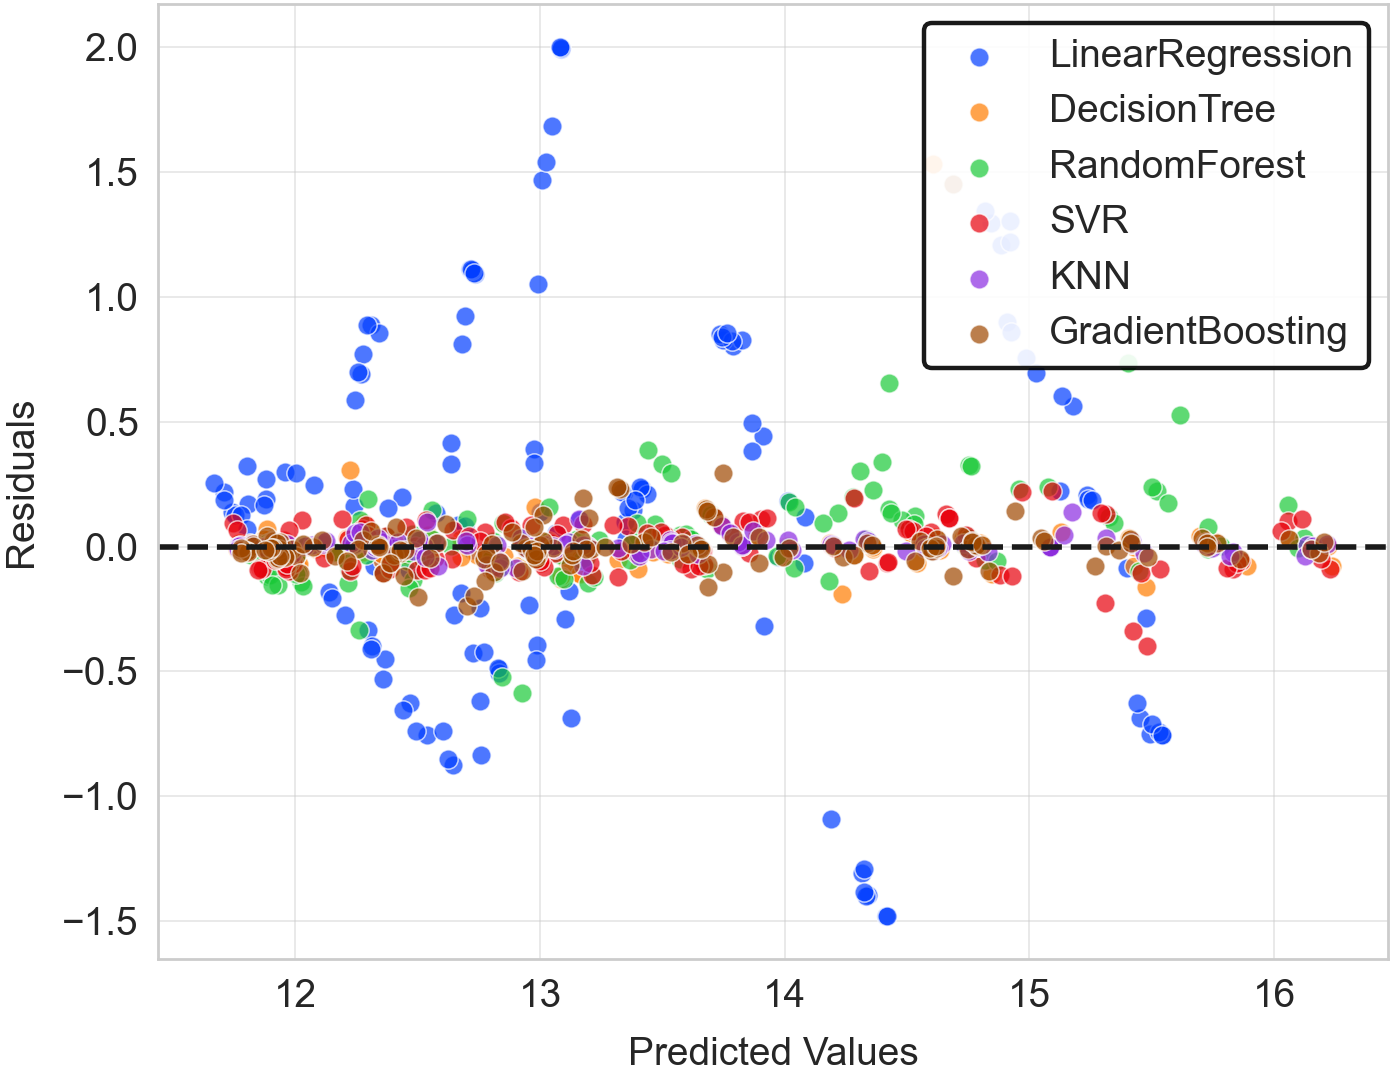

In [19]:
# %%
fig, ax3 = fig_mm(90, 70)
palette = sns.color_palette("bright", len(results))
for i, (name, data) in enumerate(results.items()):
    sns.scatterplot(x=data["predictions"], y=data["residuals"], ax=ax3, label=name, alpha=0.7, color=palette[i], s=12)
ax3.axhline(y=0, color="k", linestyle="--", linewidth=1.0)
ax3.set_xlabel("Predicted Values")
ax3.set_ylabel("Residuals")
ax3.legend(frameon=True, edgecolor="black", framealpha=0.9)
ax3.grid(True, alpha=0.5)
fig.savefig("plots/6c_residuals_vs_predicted_angle_mie.png")
plt.show()


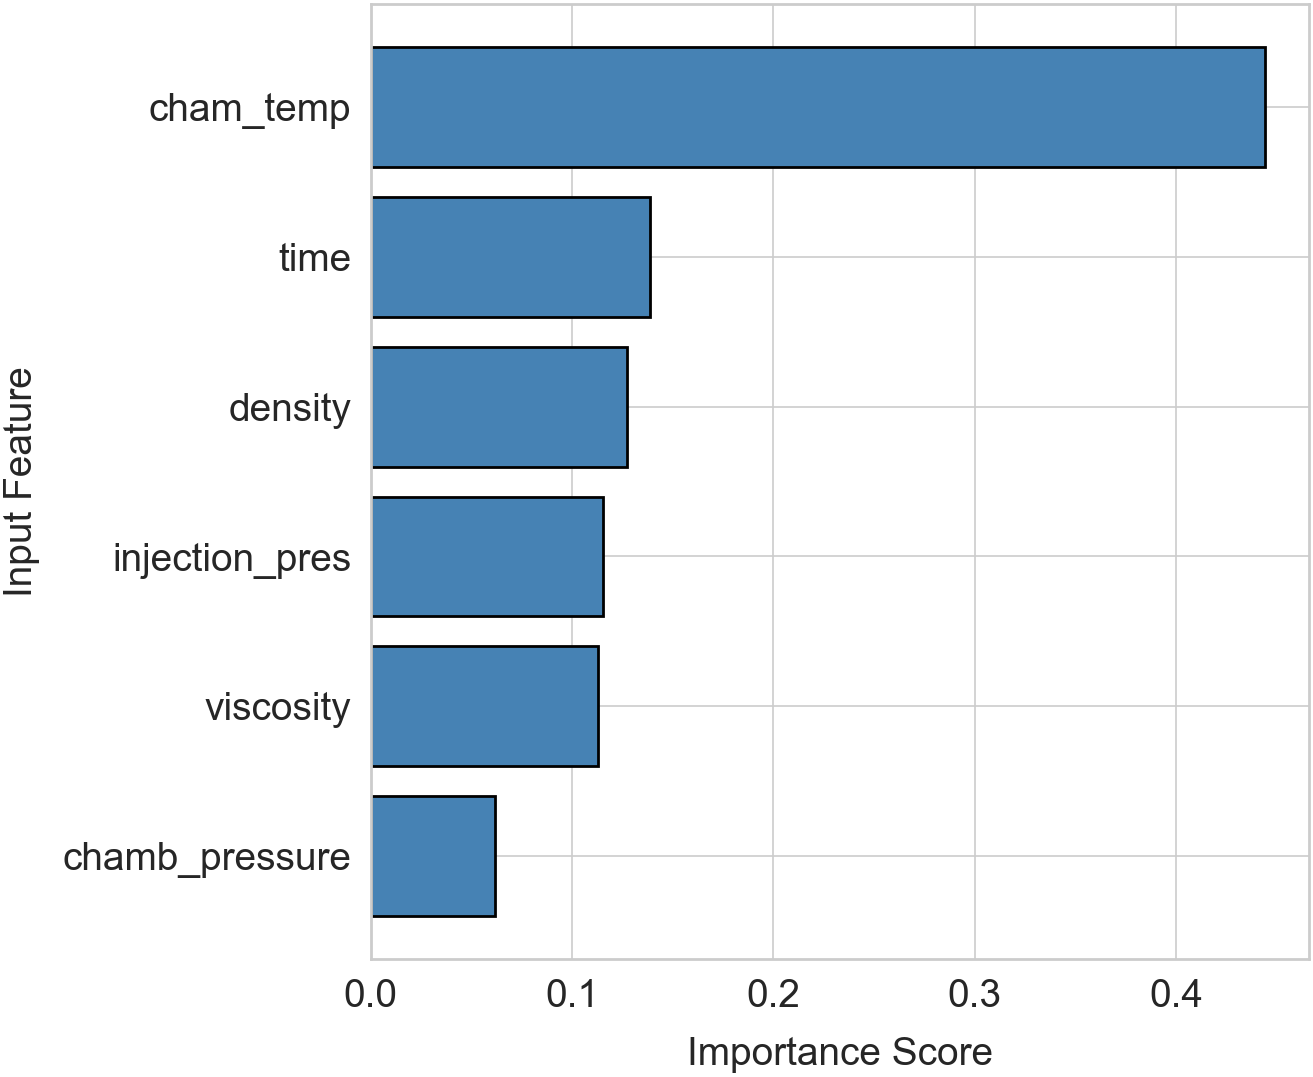

In [20]:
# %%
notebook_dir = Path.cwd()
models_dir = notebook_dir / "models"
model_path = models_dir / "RandomForest_regressor.joblib"

if model_path.exists():
    rf_model = joblib.load(model_path)
    multi_output_regressor = rf_model.named_steps["reg"]
    estimators = multi_output_regressor.estimators_
    feature_names = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
    target_names = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]
    rf_angle_mie = estimators[target_names.index("angle_mie")]
    feature_importances = rf_angle_mie.feature_importances_
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances}).sort_values("Importance", ascending=False)
    importance_df["Percentage"] = (importance_df["Importance"] / importance_df["Importance"].sum()) * 100
    fig, ax = fig_mm(85, 70)
    ax.barh(importance_df["Feature"], importance_df["Importance"], color="steelblue", edgecolor="black", linewidth=0.5)
    ax.set_xlabel("Importance Score")
    ax.set_ylabel("Input Feature")
    ax.invert_yaxis()
    fig.savefig("plots/7_feature_importance_angle_mie_rf.png")
    plt.show()
else:
    print(f"Random Forest model not found at {model_path}")


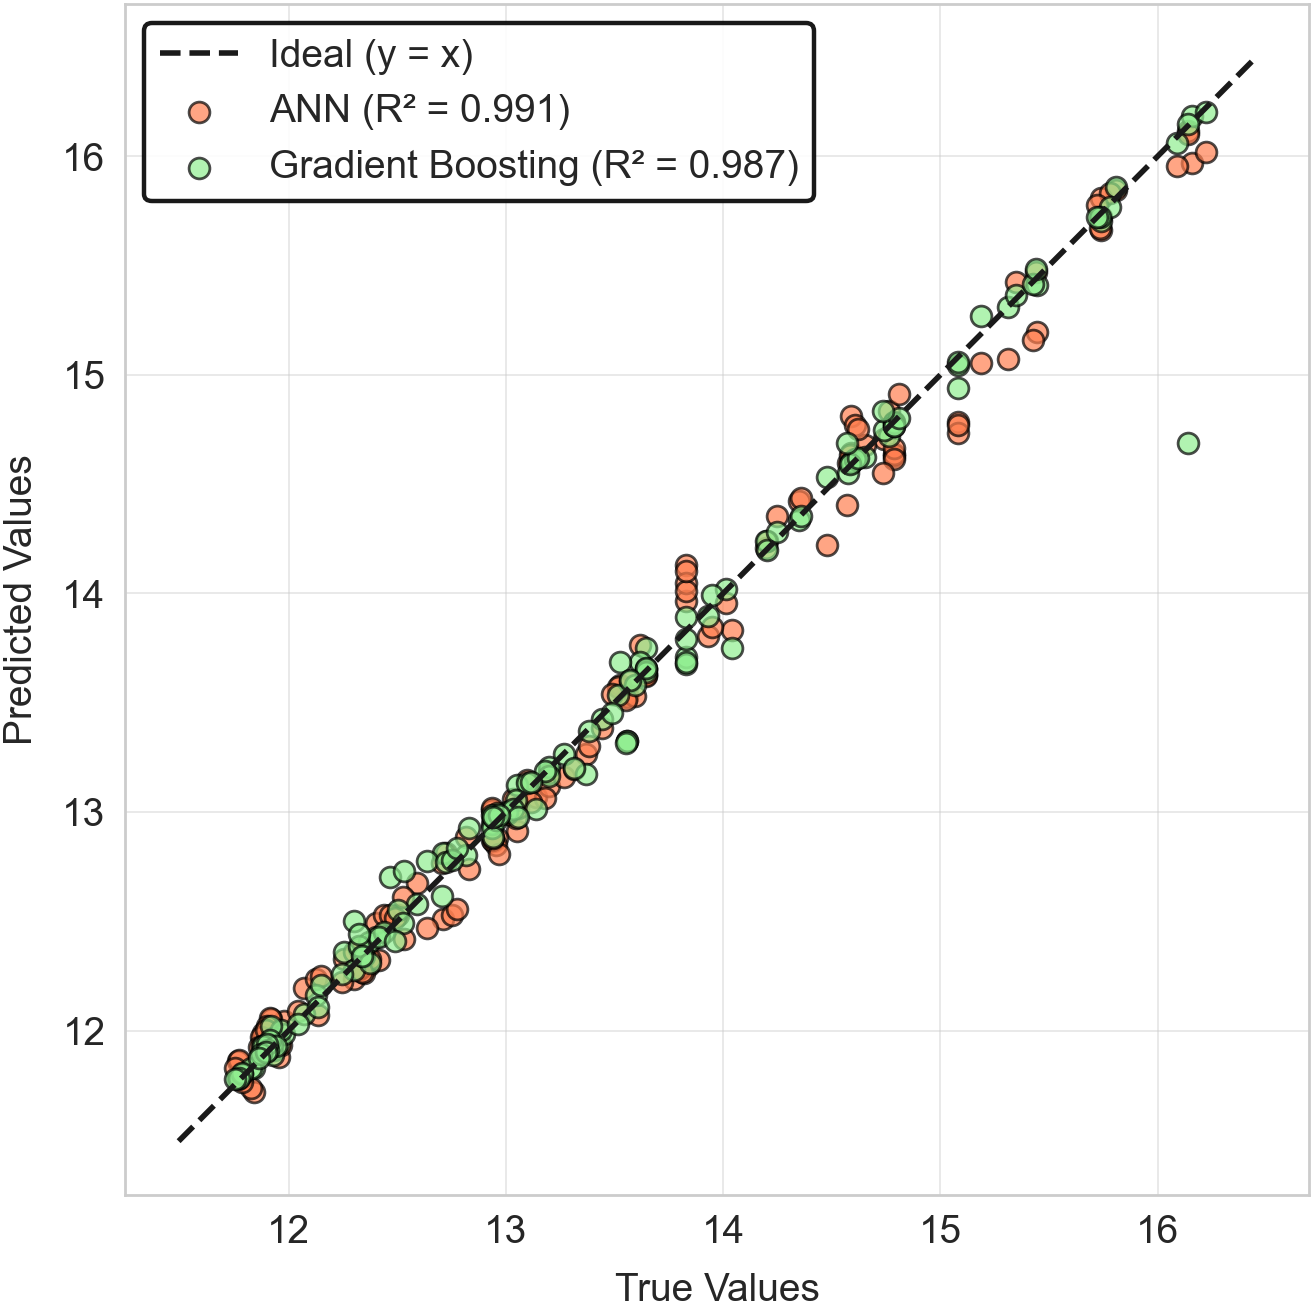

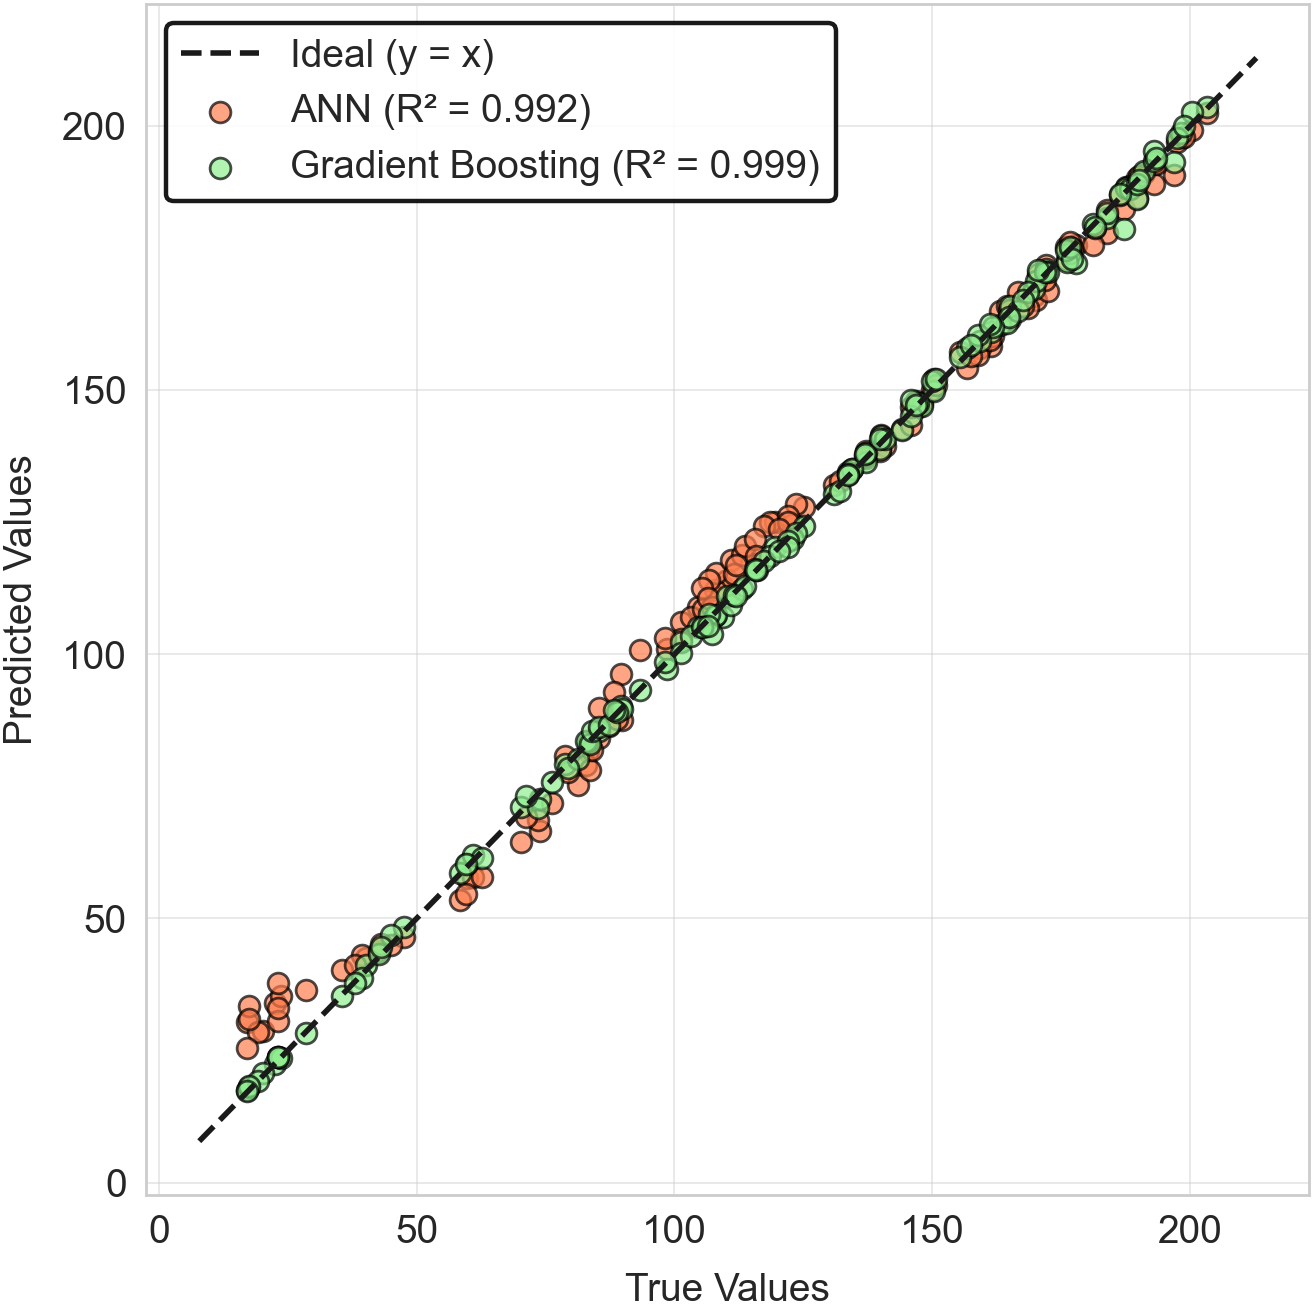

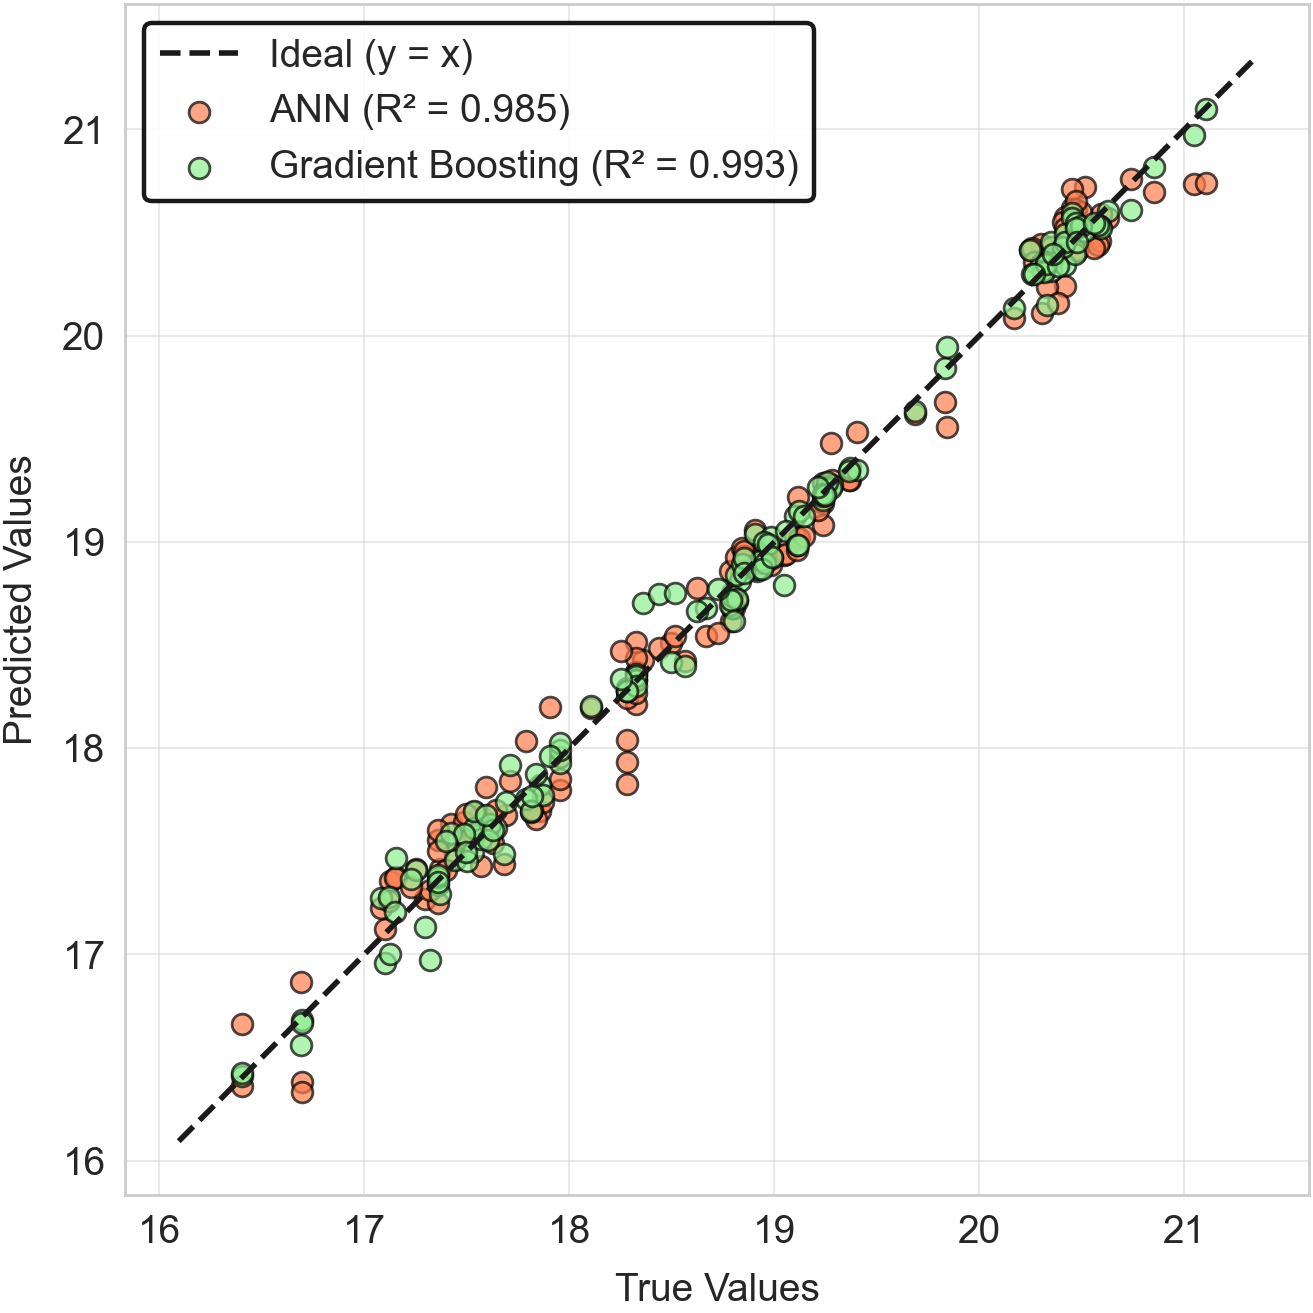

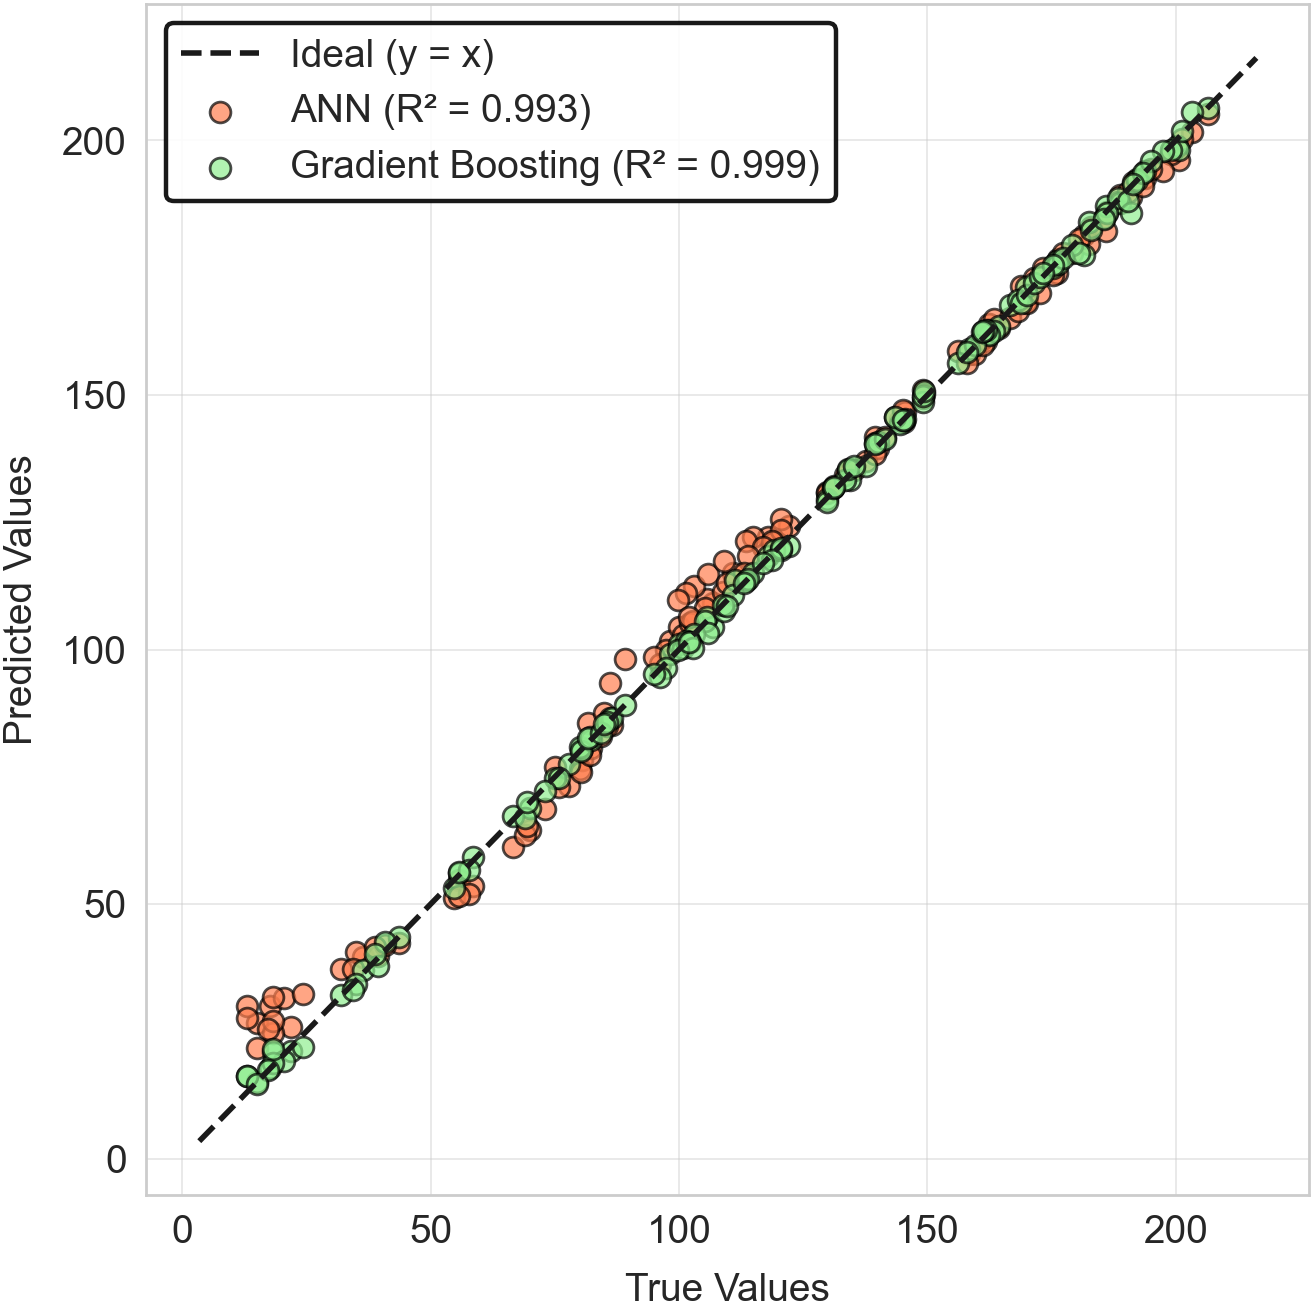

In [21]:
# %%
ann_actuals_path = "outputs/ANN_improved_actuals.csv"
ann_predictions_path = "outputs/ANN_improved_predictions.csv"

if os.path.exists(ann_actuals_path) and os.path.exists(ann_predictions_path):
    ann_actuals = pd.read_csv(ann_actuals_path)
    ann_predictions = pd.read_csv(ann_predictions_path)
    gb_model = joblib.load("models/GradientBoosting_regressor.joblib")
    X, y = df[INPUTS], df[TARGETS]
    if 'run' in df.columns:
        runs = df["run"]
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42)
    gb_predictions = gb_model.predict(X_te)
    gb_predictions_df = pd.DataFrame(gb_predictions, columns=TARGETS)
    targets = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]
    for target in targets:
        actual = ann_actuals[target].values
        ann_pred = ann_predictions[target].values
        gb_pred = gb_predictions_df[target].values
        r2_ann = r2_score(actual, ann_pred)
        r2_gb = r2_score(actual, gb_pred)
        values = np.concatenate([actual, ann_pred, gb_pred])
        min_v, max_v = values.min(), values.max()
        margin = (max_v - min_v) * 0.05
        fig, ax = fig_mm(85, 85)
        ax.plot([min_v - margin, max_v + margin], [min_v - margin, max_v + margin], "k--", label="Ideal (y = x)", lw=1.0)
        ax.scatter(actual, ann_pred, alpha=0.7, s=14, color="#FF7F50", edgecolors="black", linewidths=0.5, label=f"ANN (R² = {r2_ann:.3f})")
        ax.scatter(actual, gb_pred, alpha=0.7, s=14, color="#90EE90", edgecolors="black", linewidths=0.5, label=f"Gradient Boosting (R² = {r2_gb:.3f})")
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.legend(frameon=True, edgecolor="black", framealpha=0.9)
        ax.grid(True, alpha=0.5)
        fig.savefig(f"plots/8_ann_gb_{target}_comparison.png")
        plt.show()


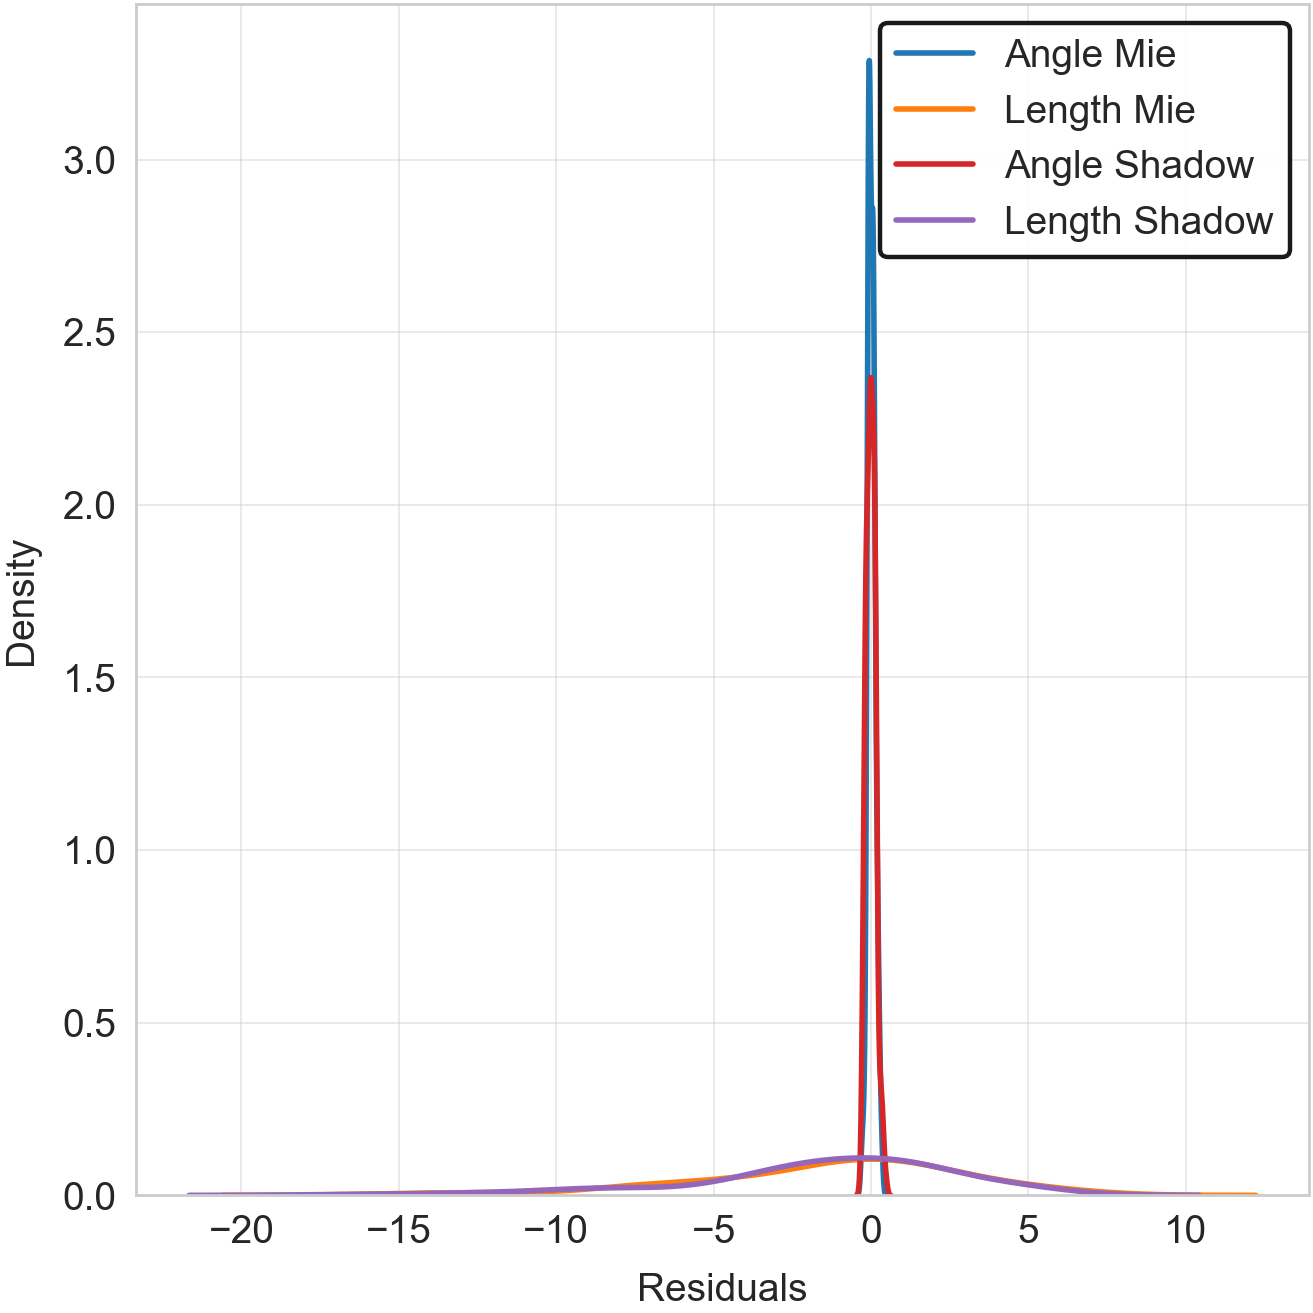

In [22]:
# %%
residuals = {t: ann_actuals[t] - ann_predictions[t] for t in targets}
fig, ax = fig_mm(85, 85)
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd"]
for i, t in enumerate(targets):
    sns.kdeplot(residuals[t], label=t.replace("_", " ").title(), color=colors[i], ax=ax)
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
ax.legend(frameon=True, edgecolor="black", framealpha=0.9)
ax.grid(True, alpha=0.5)
fig.savefig("plots/9_ann_residuals_kde.png")
plt.show()
